In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import time

# FYI: A P-value is the likelyhood that H0 is true.

In [2]:
def perform_stats(x, y):
    shapiro_x = stats.shapiro(x)[1]
    shapiro_y = stats.shapiro(y)[1]
    if shapiro_x >= 0.05:
        print("X is likely normally distributed.")
    else:
        print("X is likely not normally distributed.")
    if shapiro_y >= 0.05:
        print("Y is likely normally distributed.")
    else:
        print("Y is likely not normally distributed.")
    try:
        p_ks_xy = stats.ks_2samp(x, y)[1]
        print(f"The Kolmogorov-Smirnov test p-value: {p_ks_xy}")
    except Exception:
        print("Kolmogorov-Smirnov could not be performed!")
    try:
        p_wc_xy = stats.wilcoxon(x, y)[1]
        print(f"The Wilcoxon test p-value: {p_wc_xy}")
    except ValueError:
        p_mw_xy = stats.mannwhitneyu(x, y)[1]
        print(f"Wilcoxon could not be performed, \n"
             f"Using Mann-Whitney rank test p-value: {p_mw_xy}")
    except Exception:
        print("Neither Wilcoxon nor Mann-Whitney tests could be performed!")
    try:
        p_pears_xy = stats.pearsonr(x, y)
        print(f"The Pearson correlation: {p_pears_xy[0]},\n"
             f"p-value: {p_pears_xy[1]}")
    except Exception:
        print("Pearson correlation could not be performed!")

In [74]:
def calc_z_scores(data):
    centered = data - data.mean(axis=0)
    return centered / centered.std(axis=0)

In [3]:
data = pd.read_csv("/home/rjsietsma/Documents/School/Master_DSLS/Final_Thesis/Initial_Data_exploration/auc_results.csv", header=0, index_col=0)
data.head()

,Gene,AUC,FPR,Precision,Recall/TPR,F-score,N_benign,N_malign,m_cat,n_snvs
1,BRCA1,0.949156,0.001451,0.941821,0.998549,0.969355,848,1378,1,2226
2,LDLR,0.905925,0.006061,0.941627,0.993939,0.967076,335,990,1,1325
3,MSH2,0.955128,0.000000,0.929293,1.000000,0.963351,390,460,1,850
4,BRCA2,0.946305,0.000569,0.931034,0.999431,0.964021,1217,1756,1,2973
5,USH2A,0.944790,0.013333,0.831461,0.986667,0.902439,309,150,1,459


In [4]:
data.sort_values(by=['AUC'], ascending=True)

data = data.drop(data[data['Gene'].isna()].index)

no_m_cat = data[data['m_cat'] == 0]['Gene'].count()
total = data['Gene'].count()

print(f'The total percentage of genes that do not have multiple categories, thus no ability to calculate AUC is: ' 
      f'{round(no_m_cat/total*100, ndigits=2)}%.')

data['b/p ratio'] = data['N_benign'] / data['N_malign']
data_with_auc = data[data['AUC'].notnull()]
data_with_auc[data_with_auc['N_malign'] != 0].sort_values(by=['b/p ratio'], ascending=False)

The total percentage of genes that do not have multiple categories, thus no ability to calculate AUC is: 76.18%.


,Gene,AUC,FPR,Precision,Recall/TPR,F-score,N_benign,N_malign,m_cat,n_snvs,b/p ratio
2227,CELSR2,0.998873,0.000000,0.333333,1.000000,0.500000,887,1,1,888,887.000000
2129,KIF1B,0.991240,0.000000,0.071429,1.000000,0.133333,742,1,1,743,742.000000
2605,GIGYF2,0.483137,1.000000,0.000000,0.000000,0.000000,593,1,1,594,593.000000
2874,NRXN3,0.490248,1.000000,0.000000,0.000000,0.000000,564,1,1,565,564.000000
2619,LDB3,0.486355,1.000000,0.000000,0.000000,0.000000,513,1,1,514,513.000000
...,...,...,...,...,...,...,...,...,...,...,...
22,DDX3X,0.700000,0.000000,0.913043,1.000000,0.954545,10,63,1,73,0.158730
1071,CYP27B1,0.928571,0.142857,1.000000,0.857143,0.923077,1,7,1,8,0.142857
395,CTSK,0.833333,0.000000,0.954545,1.000000,0.976744,3,21,1,24,0.142857
210,ACADS,0.875000,0.000000,0.966667,1.000000,0.983051,4,29,1,33,0.137931


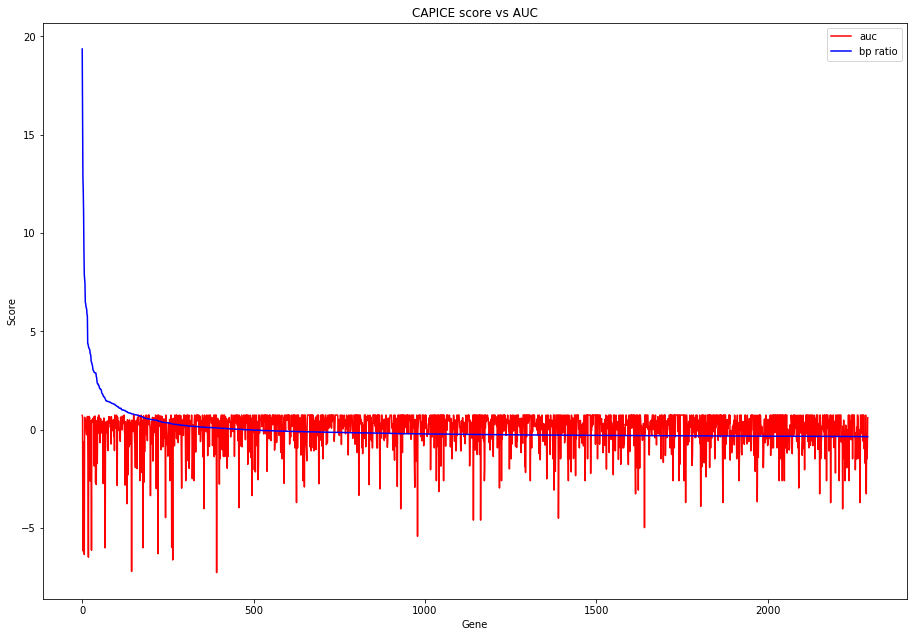

X is likely not normally distributed.
Y is likely not normally distributed.
The Kolmogorov-Smirnov test p-value: 0.0
The Wilcoxon test p-value: 0.0
The Pearson correlation: -0.14697794956240257,
p-value: 1.536657019198309e-12


In [76]:
sorted_datawithauc = data_with_auc[data_with_auc['N_malign'] != 0].sort_values(by=['b/p ratio'], ascending=False)
sorted_datawithauc.index = np.arange(sorted_datawithauc.shape[0])
fig = plt.figure(figsize=(15,10))
axes = fig.add_axes([0.1,0.1,0.8,0.8])\

sorted_datawithauc_zscores = calc_z_scores(np.array(sorted_datawithauc[["AUC",'b/p ratio']]))

axes.plot(sorted_datawithauc.index, sorted_datawithauc_zscores[:,0], c='red', label='auc')
axes.plot(sorted_datawithauc.index, sorted_datawithauc_zscores[:,1], c='blue', label='bp ratio')
# axes.plot(sorted_datawithauc.index, sorted_datawithauc['capice'], c='yellow', label='capice')
axes.set_xlabel("Gene")
axes.set_ylabel("Score")
axes.set_title("CAPICE score vs AUC")
axes.legend()
plt.show()

perform_stats(sorted_datawithauc['AUC'], sorted_datawithauc['b/p ratio'])

In [6]:
datanomcat = data[data['m_cat'] == 0]

datanomcat.sort_values(by=['AUC'], ascending=True)

list_of_odd_genes = []

for row in datanomcat['Gene'].unique():
    if isinstance(row, str):
        n_benign = datanomcat[datanomcat['Gene'] == row]['N_benign'].item()
        n_malign = datanomcat[datanomcat['Gene'] == row]['N_malign'].item()
        if n_benign != 0 and n_malign != 0:
            print(f'Gene {row} does have benign: {n_benign} and malignant: {n_malign} samples!')
            list_of_odd_genes.append(row)
    else:
        print(f'Encountered not a gene!: {row}')
        


Gene TCF20 does have benign: 2 and malignant: 6 samples!
Gene GMNN does have benign: 3 and malignant: 3 samples!
Gene SLC6A9 does have benign: 2 and malignant: 2 samples!
Gene MRPS34 does have benign: 1 and malignant: 2 samples!
Gene RAB11B does have benign: 2 and malignant: 2 samples!
Gene RBP3 does have benign: 26 and malignant: 1 samples!
Gene HPS6 does have benign: 16 and malignant: 1 samples!
Gene TMPRSS6 does have benign: 14 and malignant: 1 samples!
Gene CEACAM16 does have benign: 215 and malignant: 1 samples!
Gene SLC25A3 does have benign: 7 and malignant: 1 samples!
Gene IL1RN does have benign: 18 and malignant: 1 samples!
Gene GRID2 does have benign: 5 and malignant: 1 samples!
Gene NLRP1 does have benign: 14 and malignant: 1 samples!
Gene LIPE does have benign: 2 and malignant: 1 samples!
Gene NDUFA1 does have benign: 11 and malignant: 1 samples!


In [7]:
datanomcat = datanomcat.drop(datanomcat[datanomcat['Gene'].isna()].index)
datanomcat.sort_values(by=['N_malign'],ascending=True)

,Gene,AUC,FPR,Precision,Recall/TPR,F-score,N_benign,N_malign,m_cat,n_snvs,b/p ratio
5958,CIDEB,NaN,NaN,NaN,NaN,NaN,3,0,0,3,inf
7186,TRAPPC4,NaN,NaN,NaN,NaN,NaN,5,0,0,5,inf
7185,PSMD8,NaN,NaN,NaN,NaN,NaN,1,0,0,1,inf
7184,KDM4E,NaN,NaN,NaN,NaN,NaN,1,0,0,1,inf
7183,WBP2NL,NaN,NaN,NaN,NaN,NaN,7,0,0,7,inf
...,...,...,...,...,...,...,...,...,...,...,...
219,DNAAF5,NaN,NaN,NaN,NaN,NaN,0,5,0,5,0.000000
629,TCF20,NaN,NaN,NaN,NaN,NaN,2,6,0,8,0.333333
941,P3H1,NaN,NaN,NaN,NaN,NaN,0,9,0,9,0.000000
446,ADGRG1,NaN,NaN,NaN,NaN,NaN,0,17,0,17,0.000000


In [8]:
datanomcat.sort_values(by=['N_benign'], ascending=False)

,Gene,AUC,FPR,Precision,Recall/TPR,F-score,N_benign,N_malign,m_cat,n_snvs,b/p ratio
2225,MIR548N,NaN,NaN,NaN,NaN,NaN,10289,0,0,10289,inf
2140,MIR548AZ,NaN,NaN,NaN,NaN,NaN,8781,0,0,8781,inf
2329,MIR1268A,NaN,NaN,NaN,NaN,NaN,7648,0,0,7648,inf
2610,MYHAS,NaN,NaN,NaN,NaN,NaN,6946,0,0,6946,inf
2093,MIR1273H,NaN,NaN,NaN,NaN,NaN,4103,0,0,4103,inf
...,...,...,...,...,...,...,...,...,...,...,...
1759,PIBF1,NaN,NaN,NaN,NaN,NaN,0,2,0,2,0.0
1751,VAC14,NaN,NaN,NaN,NaN,NaN,0,1,0,1,0.0
1728,SLC27A4,NaN,NaN,NaN,NaN,NaN,0,1,0,1,0.0
1709,WARS2,NaN,NaN,NaN,NaN,NaN,0,2,0,2,0.0


In [9]:
datanomcat.sort_values(by=['N_malign'], ascending=False)

,Gene,AUC,FPR,Precision,Recall/TPR,F-score,N_benign,N_malign,m_cat,n_snvs,b/p ratio
139,ADGRV1,NaN,NaN,NaN,NaN,NaN,0,36,0,36,0.000000
446,ADGRG1,NaN,NaN,NaN,NaN,NaN,0,17,0,17,0.000000
941,P3H1,NaN,NaN,NaN,NaN,NaN,0,9,0,9,0.000000
629,TCF20,NaN,NaN,NaN,NaN,NaN,2,6,0,8,0.333333
219,DNAAF5,NaN,NaN,NaN,NaN,NaN,0,5,0,5,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
4779,RB1CC1,NaN,NaN,NaN,NaN,NaN,3,0,0,3,inf
4778,NOL4,NaN,NaN,NaN,NaN,NaN,1,0,0,1,inf
4777,MKI67,NaN,NaN,NaN,NaN,NaN,7,0,0,7,inf
4776,ZNF365,NaN,NaN,NaN,NaN,NaN,2,0,0,2,inf


In [10]:

usable = data[data['m_cat'] == 1]
filter1 = usable["N_benign"] > 5
filter2 = usable['N_malign'] > 5
m_cat_filtered_usable = usable.where(filter1 & filter2).dropna()
m_cat_filtered_usable.sort_values(by=['AUC'], ascending=True)

,Gene,AUC,FPR,Precision,Recall/TPR,F-score,N_benign,N_malign,m_cat,n_snvs,b/p ratio
792,ANOS1,0.642857,0.000000,0.750000,1.000000,0.857143,7.0,15.0,1.0,22.0,0.466667
1168,ARID2,0.652174,0.000000,0.448276,1.000000,0.619048,23.0,13.0,1.0,36.0,1.769231
459,EBF3,0.666667,0.000000,0.703704,1.000000,0.826087,12.0,19.0,1.0,31.0,0.631579
1373,RPL5,0.669643,0.285714,0.625000,0.714286,0.666667,8.0,7.0,1.0,15.0,1.142857
22,DDX3X,0.700000,0.000000,0.913043,1.000000,0.954545,10.0,63.0,1.0,73.0,0.158730
...,...,...,...,...,...,...,...,...,...,...,...
393,HMBS,1.000000,0.000000,1.000000,1.000000,1.000000,21.0,14.0,1.0,35.0,1.500000
1409,GUCY2D,1.000000,0.000000,1.000000,1.000000,1.000000,35.0,10.0,1.0,45.0,3.500000
285,XPA,1.000000,0.000000,1.000000,1.000000,1.000000,7.0,6.0,1.0,13.0,1.166667
1100,ALDOB,1.000000,0.000000,1.000000,1.000000,1.000000,16.0,16.0,1.0,32.0,1.000000


In [11]:
filter_auc_nan = data['AUC'].isna()
new_data = data.where(~filter_auc_nan).dropna()
new_data.sort_values(by=['n_snvs'], ascending=False)

,Gene,AUC,FPR,Precision,Recall/TPR,F-score,N_benign,N_malign,m_cat,n_snvs,b/p ratio
141,TTN,0.960966,0.007587,0.703226,0.992413,0.823159,3916.0,659.0,1.0,4575.0,5.942337
4,BRCA2,0.946305,0.000569,0.931034,0.999431,0.964021,1217.0,1756.0,1.0,2973.0,0.693052
1,BRCA1,0.949156,0.001451,0.941821,0.998549,0.969355,848.0,1378.0,1.0,2226.0,0.615385
2230,CACNA1H,0.899059,0.200000,0.500000,0.800000,0.615385,2126.0,5.0,1.0,2131.0,425.200000
861,RYR2,0.962710,0.024096,0.450000,0.975904,0.615970,1961.0,83.0,1.0,2044.0,23.626506
...,...,...,...,...,...,...,...,...,...,...,...
937,TRMT5,1.000000,0.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,2.0,1.000000
1542,RSPO4,1.000000,0.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,2.0,1.000000
1727,FAR1,1.000000,0.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,2.0,1.000000
2355,KIAA0556,1.000000,0.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,2.0,1.000000


In [12]:
new_data_log_transformed = new_data.copy()

def sigmoid(x):
    return 1/(1+np.exp(-x))

total_snvs = new_data_log_transformed['n_snvs'].sum()
total_benign = new_data_log_transformed['N_benign'].sum()
total_malign = new_data_log_transformed['N_malign'].sum()

new_data_log_transformed['n_snvs'] = new_data_log_transformed['n_snvs'].apply(lambda x: x/total_snvs*100)
new_data_log_transformed['N_benign'] = new_data_log_transformed['N_benign'].apply(lambda x: x/total_benign*100)
new_data_log_transformed['N_malign'] = new_data_log_transformed['N_malign'].apply(lambda x: x/total_malign*100)

# new_data_log_transformed['n_snvs'] = sigmoid(new_data_log_transformed['n_snvs'])

new_data_log_transformed.sort_values(by=['n_snvs'], ascending=False)

,Gene,AUC,FPR,Precision,Recall/TPR,F-score,N_benign,N_malign,m_cat,n_snvs,b/p ratio
141,TTN,0.960966,0.007587,0.703226,0.992413,0.823159,2.601872,1.627482,1.0,2.395300,5.942337
4,BRCA2,0.946305,0.000569,0.931034,0.999431,0.964021,0.808600,4.336659,1.0,1.556553,0.693052
1,BRCA1,0.949156,0.001451,0.941821,0.998549,0.969355,0.563429,3.403141,1.0,1.165451,0.615385
2230,CACNA1H,0.899059,0.200000,0.500000,0.800000,0.615385,1.412559,0.012348,1.0,1.115713,425.200000
861,RYR2,0.962710,0.024096,0.450000,0.975904,0.615970,1.302929,0.204979,1.0,1.070163,23.626506
...,...,...,...,...,...,...,...,...,...,...,...
937,TRMT5,1.000000,0.000000,1.000000,1.000000,1.000000,0.000664,0.002470,1.0,0.001047,1.000000
1542,RSPO4,1.000000,0.000000,1.000000,1.000000,1.000000,0.000664,0.002470,1.0,0.001047,1.000000
1727,FAR1,1.000000,0.000000,1.000000,1.000000,1.000000,0.000664,0.002470,1.0,0.001047,1.000000
2355,KIAA0556,1.000000,0.000000,1.000000,1.000000,1.000000,0.000664,0.002470,1.0,0.001047,1.000000


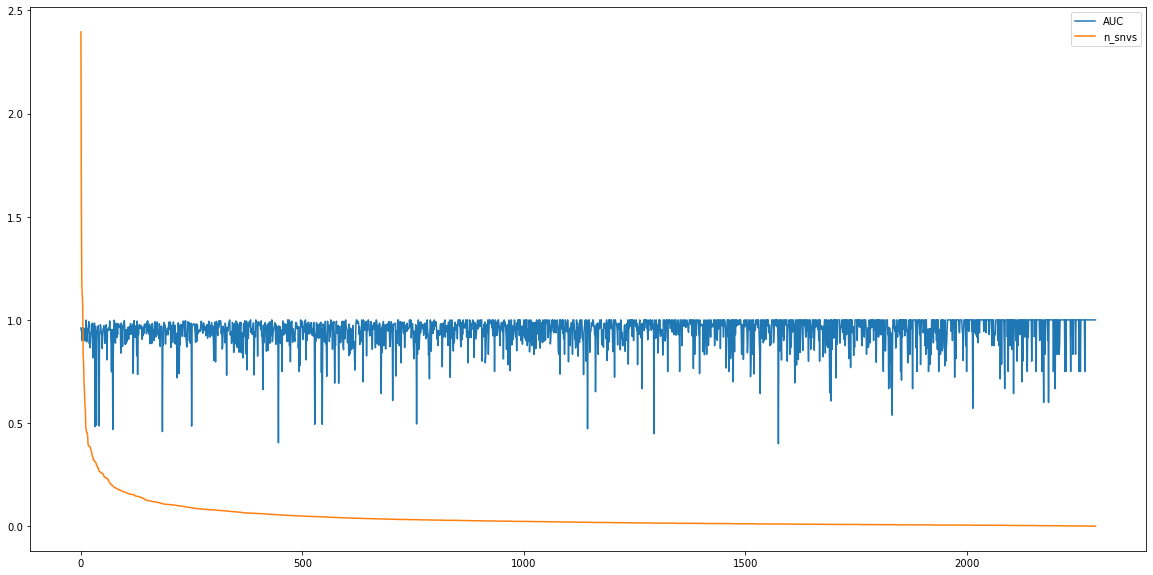

X is likely not normally distributed.
Y is likely not normally distributed.
The Kolmogorov-Smirnov test p-value: 0.0
The Wilcoxon test p-value: 0.0
The Pearson correlation: -0.05824380639051708,
p-value: 0.005282870460370442


In [13]:
temp_data = new_data_log_transformed[['AUC', 'n_snvs']]
temp_data = temp_data.sort_values(by=['n_snvs'], ascending=False)
temp_data.index = np.arange(temp_data.shape[0])
temp_data.plot(figsize=(20,10))
plt.show()

perform_stats(temp_data['AUC'], temp_data['n_snvs'])
# Due to this plot, I see that there's not really a corrrelation in the number of snvs and the AUC

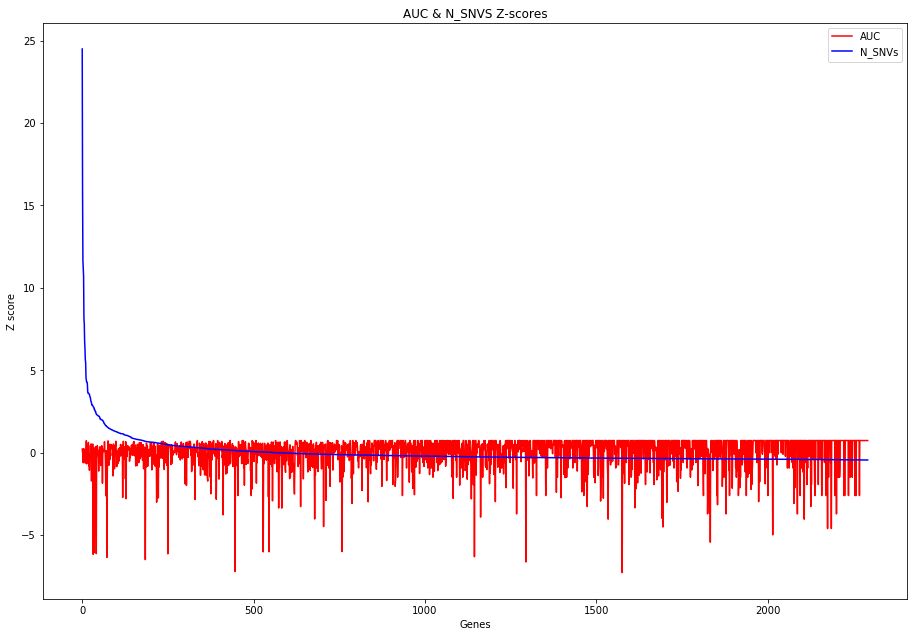

X is likely not normally distributed.
Y is likely not normally distributed.
The Kolmogorov-Smirnov test p-value: 1.3980921410372214e-178
The Wilcoxon test p-value: 9.235675609072022e-21
The Pearson correlation: -0.05824380639051719,
p-value: 0.005282870460369822


In [82]:
temp_data = calc_z_scores(np.array(new_data[['AUC', 'n_snvs']].sort_values(by=['n_snvs'], ascending=False)))
indexing = np.arange(new_data.shape[0])
fig = plt.figure(figsize=(15,10))
axes = fig.add_axes([0.1,0.1,0.8,0.8])
axes.plot(indexing, temp_data[:,0], c='red', label='AUC')
axes.plot(indexing, temp_data[:,1], c='blue', label='N_SNVs')
axes.set_xlabel("Genes")
axes.set_ylabel("Z score")
axes.set_title("AUC & N_SNVS Z-scores")
axes.legend()
plt.show()

perform_stats(temp_data[:,0],temp_data[:,1])

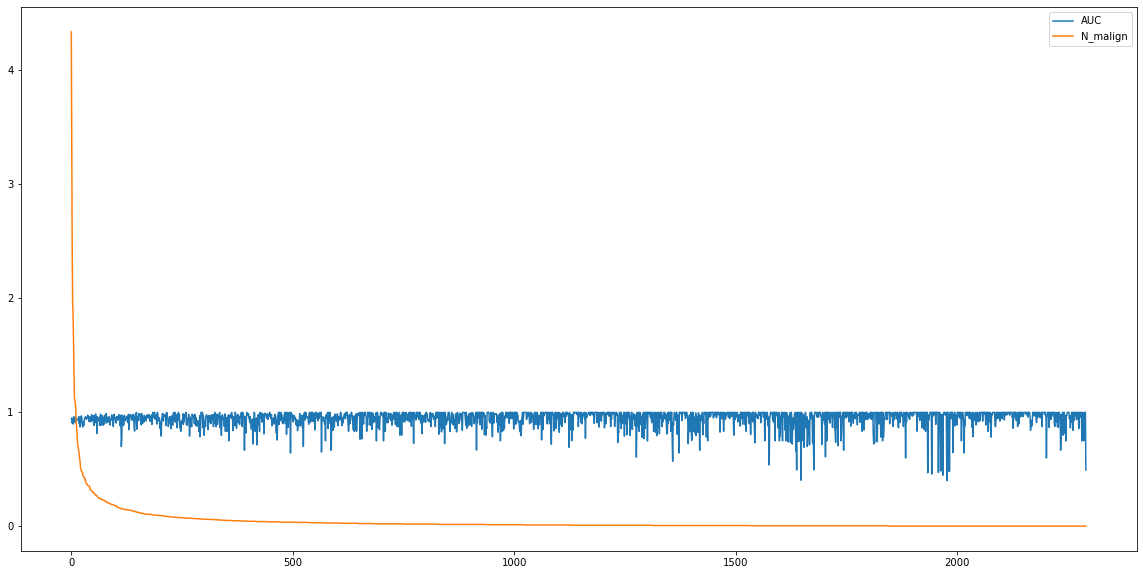

X is likely not normally distributed.
Y is likely not normally distributed.
The Kolmogorov-Smirnov test p-value: 0.0
The Wilcoxon test p-value: 0.0
The Pearson correlation: -0.021797811600122546,
p-value: 0.29689210525852705


In [14]:
temp_data = new_data_log_transformed[['AUC', 'N_malign']]
temp_data = temp_data.sort_values(by=['N_malign'], ascending=False)
temp_data.index = np.arange(temp_data.shape[0])
temp_data.plot(figsize=(20,10))
plt.show()

perform_stats(temp_data['AUC'], temp_data['N_malign'])

# More stable, especially in the first 1000 genes

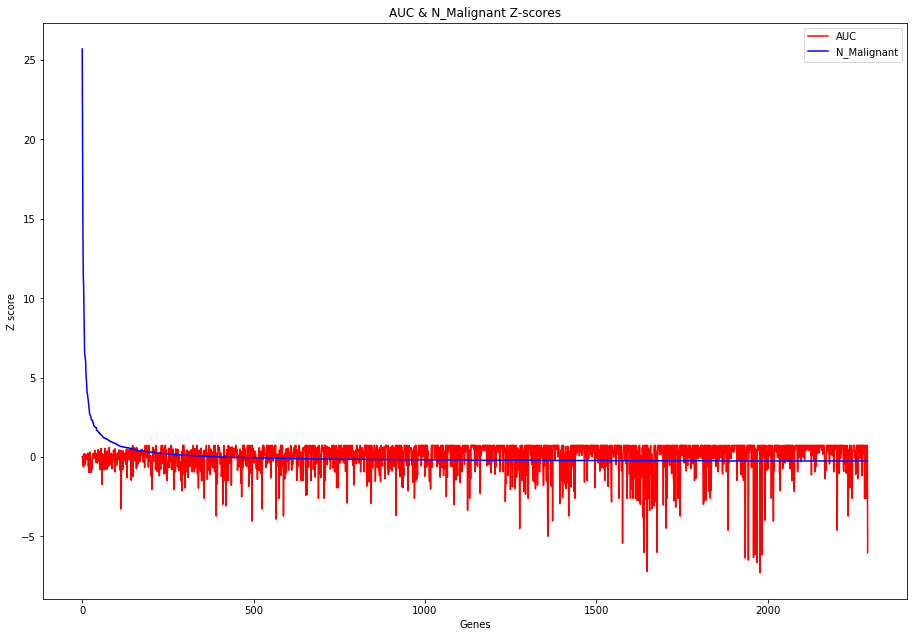

X is likely not normally distributed.
Y is likely not normally distributed.
The Kolmogorov-Smirnov test p-value: 1.0616195561351068e-246
The Wilcoxon test p-value: 1.4771412057399952e-23
The Pearson correlation: -0.021797811600122476,
p-value: 0.29689210525852705


In [83]:
temp_data = calc_z_scores(np.array(new_data[['AUC', 'N_malign']].sort_values(by=['N_malign'], ascending=False)))
indexing = np.arange(new_data.shape[0])
fig = plt.figure(figsize=(15,10))
axes = fig.add_axes([0.1,0.1,0.8,0.8])
axes.plot(indexing, temp_data[:,0], c='red', label='AUC')
axes.plot(indexing, temp_data[:,1], c='blue', label='N_Malignant')
axes.set_xlabel("Genes")
axes.set_ylabel("Z score")
axes.set_title("AUC & N_Malignant Z-scores")
axes.legend()
plt.show()

perform_stats(temp_data[:,0],temp_data[:,1])

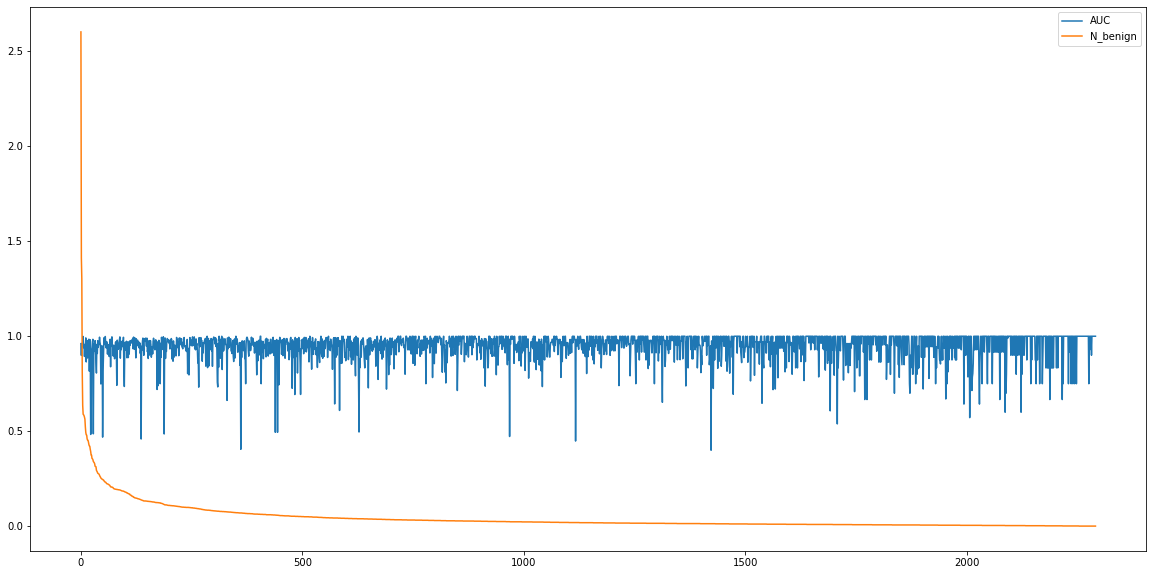

X is likely not normally distributed.
Y is likely not normally distributed.
The Kolmogorov-Smirnov test p-value: 0.0
The Wilcoxon test p-value: 0.0
The Pearson correlation: -0.06465003902379769,
p-value: 0.0019571325795049908


In [15]:
temp_data = new_data_log_transformed[['AUC', 'N_benign']]
temp_data = temp_data.sort_values(by=['N_benign'], ascending=False)
temp_data.index = np.arange(temp_data.shape[0])
temp_data.plot(figsize=(20,10))
plt.show()

perform_stats(temp_data['AUC'], temp_data['N_benign'])

# Some more fluctiations, but still at the end it seems to be somewhat of a correlation.

# //TODO: add ratio pathogenic vs benign

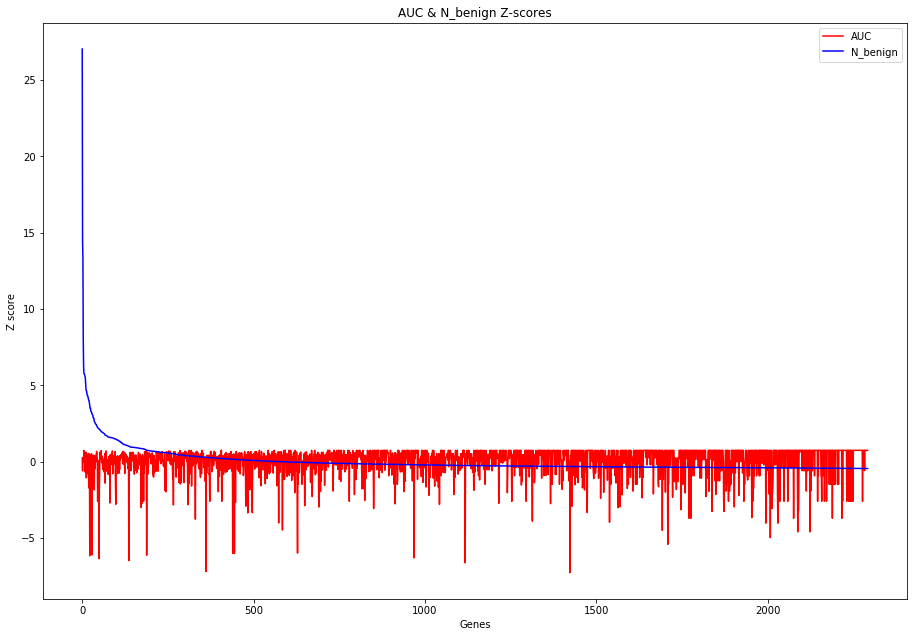

X is likely not normally distributed.
Y is likely not normally distributed.
The Kolmogorov-Smirnov test p-value: 6.778023521061403e-176
The Wilcoxon test p-value: 2.362745773366776e-20
The Pearson correlation: -0.06465003902379786,
p-value: 0.0019571325795047613


In [84]:
temp_data = calc_z_scores(np.array(new_data[['AUC', 'N_benign']].sort_values(by=['N_benign'], ascending=False)))
indexing = np.arange(new_data.shape[0])
fig = plt.figure(figsize=(15,10))
axes = fig.add_axes([0.1,0.1,0.8,0.8])
axes.plot(indexing, temp_data[:,0], c='red', label='AUC')
axes.plot(indexing, temp_data[:,1], c='blue', label='N_benign')
axes.set_xlabel("Genes")
axes.set_ylabel("Z score")
axes.set_title("AUC & N_benign Z-scores")
axes.legend()
plt.show()

perform_stats(temp_data[:,0],temp_data[:,1])

In [16]:
n_genes_nes = data['AUC'].isna().sum()
n_genes_es = data['AUC'].dropna().count()
print(f'Amount of genes that have enough SNVs for an AUC: {n_genes_es}, \n'
     f'amount of genes that do not have enough SNVs: {n_genes_nes}.')

Amount of genes that have enough SNVs for an AUC: 2292, 
amount of genes that do not have enough SNVs: 7330.


In [17]:
auc_snv_data = pd.read_csv("/home/rjsietsma/Documents/School/Master_DSLS/Final_Thesis/Initial_Data_exploration/test_results_genes_auc.csv", header=0, index_col=0)
auc_snv_data.head()

,#Chrom,Pos,Ref,Alt,max_AF,Consequence,label,revel,clinpred,sift,provean,PHRED,fathmm_score,capice,ponp2,gene,auc
0,21,33974174,C,G,0.000058,STOP_LOST,LB/B,NaN,NaN,NaN,NaN,15.050,NaN,0.003275,NaN,C21orf59,NaN
1,21,33974278,C,CA,0.000045,FRAME_SHIFT,LB/B,NaN,NaN,NaN,NaN,35.000,NaN,0.304741,NaN,C21orf59,NaN
2,X,99661625,G,C,0.000037,SYNONYMOUS,LB/B,NaN,NaN,0.00,-0.00,0.806,NaN,0.000075,NaN,PCDH19,0.906593
3,X,99663098,G,GT,0.000013,STOP_GAINED,LB/B,NaN,NaN,NaN,NaN,35.000,NaN,0.998694,NaN,PCDH19,0.906593
4,X,99662275,C,G,0.000212,NON_SYNONYMOUS,LB/B,0.527,NaN,0.95,2.51,27.000,NaN,0.863940,0.436,PCDH19,0.906593


In [18]:
auc_full_data = auc_snv_data[~auc_snv_data['auc'].isna()]
auc_full_data

,#Chrom,Pos,Ref,Alt,max_AF,Consequence,label,revel,clinpred,sift,provean,PHRED,fathmm_score,capice,ponp2,gene,auc
2,X,99661625,G,C,0.000037,SYNONYMOUS,LB/B,NaN,NaN,0.000,-0.00,0.806,NaN,0.000075,NaN,PCDH19,0.906593
3,X,99663098,G,GT,0.000013,STOP_GAINED,LB/B,NaN,NaN,NaN,NaN,35.000,NaN,0.998694,NaN,PCDH19,0.906593
4,X,99662275,C,G,0.000212,NON_SYNONYMOUS,LB/B,0.527,NaN,0.950,2.51,27.000,NaN,0.863940,0.436,PCDH19,0.906593
5,X,99657670,A,ACCCAG,0.000000,FRAME_SHIFT,LP/P,NaN,NaN,NaN,NaN,35.000,NaN,0.687628,NaN,PCDH19,0.906593
6,17,29509638,C,T,0.000000,SYNONYMOUS,LB/B,NaN,NaN,0.647,-0.00,10.760,NaN,0.001511,NaN,NF1,0.922413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10539,X,19368150,A,AAGA,0.000000,INFRAME,LP/P,NaN,NaN,NaN,8.92,19.510,NaN,0.121208,NaN,PDHA1,0.894737
10541,2,31754497,T,C,0.000033,NONCODING_CHANGE,LP/P,NaN,NaN,NaN,NaN,19.790,0.951270,0.918898,NaN,SRD5A2,0.921053
10542,2,31754393,C,T,0.000000,NONCODING_CHANGE,LP/P,NaN,NaN,NaN,NaN,21.700,NaN,0.985064,NaN,SRD5A2,0.921053
10543,2,31758741,T,C,0.000200,NONCODING_CHANGE,LP/P,NaN,NaN,NaN,NaN,20.800,0.912937,0.474717,NaN,SRD5A2,0.921053


In [19]:
auc_full_data['label'] = auc_full_data['label'].replace({'LB/B':0,'LP/P':1})
auc_full_data

<ipython-input-19-8a86bb65a478>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  auc_full_data['label'] = auc_full_data['label'].replace({'LB/B':0,'LP/P':1})


,#Chrom,Pos,Ref,Alt,max_AF,Consequence,label,revel,clinpred,sift,provean,PHRED,fathmm_score,capice,ponp2,gene,auc
2,X,99661625,G,C,0.000037,SYNONYMOUS,0,NaN,NaN,0.000,-0.00,0.806,NaN,0.000075,NaN,PCDH19,0.906593
3,X,99663098,G,GT,0.000013,STOP_GAINED,0,NaN,NaN,NaN,NaN,35.000,NaN,0.998694,NaN,PCDH19,0.906593
4,X,99662275,C,G,0.000212,NON_SYNONYMOUS,0,0.527,NaN,0.950,2.51,27.000,NaN,0.863940,0.436,PCDH19,0.906593
5,X,99657670,A,ACCCAG,0.000000,FRAME_SHIFT,1,NaN,NaN,NaN,NaN,35.000,NaN,0.687628,NaN,PCDH19,0.906593
6,17,29509638,C,T,0.000000,SYNONYMOUS,0,NaN,NaN,0.647,-0.00,10.760,NaN,0.001511,NaN,NF1,0.922413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10539,X,19368150,A,AAGA,0.000000,INFRAME,1,NaN,NaN,NaN,8.92,19.510,NaN,0.121208,NaN,PDHA1,0.894737
10541,2,31754497,T,C,0.000033,NONCODING_CHANGE,1,NaN,NaN,NaN,NaN,19.790,0.951270,0.918898,NaN,SRD5A2,0.921053
10542,2,31754393,C,T,0.000000,NONCODING_CHANGE,1,NaN,NaN,NaN,NaN,21.700,NaN,0.985064,NaN,SRD5A2,0.921053
10543,2,31758741,T,C,0.000200,NONCODING_CHANGE,1,NaN,NaN,NaN,NaN,20.800,0.912937,0.474717,NaN,SRD5A2,0.921053


In [20]:
benign_data = auc_full_data[auc_full_data['label'] == 0]
malign_data = auc_full_data[auc_full_data['label'] == 1]

7320


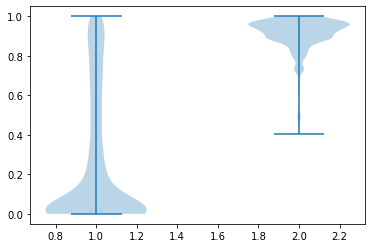

In [21]:
benign_subset = benign_data[['capice','auc']]
numpy_b_sub = np.array(benign_subset)
print(numpy_b_sub.size)
plt.violinplot(numpy_b_sub)
plt.show()

10572


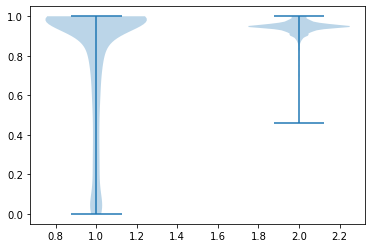

In [22]:
malign_subset = malign_data[['capice','auc']]
numpy_b_sub = np.array(malign_subset)
print(numpy_b_sub.size)
plt.violinplot(numpy_b_sub)
plt.show()

# From these plots, I see that more pathogenic samples are present, but also pathogenic is more accurate.

In [23]:
# Some statistics on the distributions of the capice scores between Malignant and Benign
perform_stats(benign_data['capice'], malign_data['capice'])

X is likely not normally distributed.
Y is likely not normally distributed.
The Kolmogorov-Smirnov test p-value: 1.0
Wilcoxon could not be performed, 
Using Mann-Whitney rank test p-value: 0.0
Pearson correlation could not be performed!


/usr/lib/python3.8/site-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


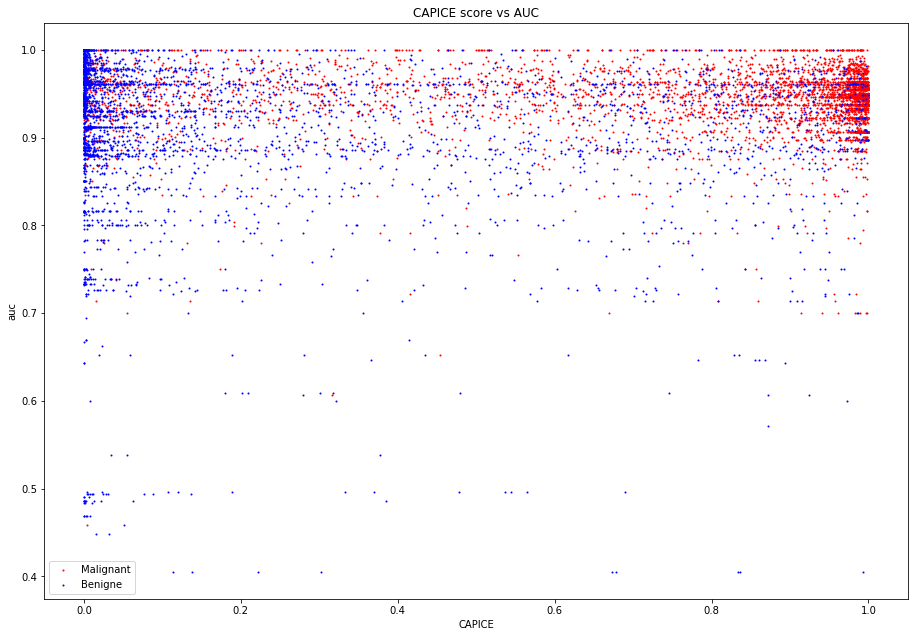

X is likely not normally distributed.
Y is likely not normally distributed.
The Kolmogorov-Smirnov test p-value: 1.0
Wilcoxon could not be performed, 
Using Mann-Whitney rank test p-value: 9.492438049817537e-73
Pearson correlation could not be performed!
We have statistical power to reject H0 hypothesis. P = 8.840980734389197e-116


In [24]:
fig = plt.figure(figsize=(15,10))
axes = fig.add_axes([0.1,0.1,0.8,0.8])

axes.scatter(malign_subset['capice'], malign_subset['auc'], c='red', label='Malignant', s=1)
axes.scatter(benign_subset['capice'], benign_subset['auc'], c='blue', label='Benigne', s=1)
axes.set_xlabel("CAPICE")
axes.set_ylabel("auc")
axes.set_title("CAPICE score vs AUC")
axes.legend()
plt.show()

perform_stats(malign_subset['auc'], benign_subset['auc'])

t2, p2 = stats.ttest_ind(malign_subset['auc'],benign_subset['auc'], equal_var=False)
if p2 >= 0.05:
    print(f'We fail to reject H0 hypothesis. P = {p2}')
else:
    print(f'We have statistical power to reject H0 hypothesis. P = {p2}')
# P < 0.05, so we can accept H0.

In [25]:
malign_data.sort_values(by=['auc','capice'], ascending=True)
# From these results, there is not really a gene that springs out, at least (see next code block)

,#Chrom,Pos,Ref,Alt,max_AF,Consequence,label,revel,clinpred,sift,provean,PHRED,fathmm_score,capice,ponp2,gene,auc
8713,14,78043194,G,A,0.000045,NON_SYNONYMOUS,1,0.119,0.948083,0.999,3.10,23.9,NaN,0.004144,0.766,SPTLC2,0.458937
4694,4,140291436,GAAGAA,G,0.000000,FRAME_SHIFT,1,NaN,NaN,NaN,NaN,35.0,NaN,0.316003,NaN,NAA15,0.607143
4036,12,46230586,A,AAACG,0.000000,FRAME_SHIFT,1,NaN,NaN,NaN,NaN,31.0,NaN,0.454109,NaN,ARID2,0.652174
4113,2,72725621,A,C,0.000000,STOP_GAINED,1,NaN,NaN,NaN,NaN,35.0,NaN,0.054396,NaN,EXOC6B,0.700000
9700,X,41205629,G,A,0.000000,NON_SYNONYMOUS,1,0.743,NaN,1.000,4.29,26.2,NaN,0.669419,0.798,DDX3X,0.700000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9190,19,55665513,C,T,0.000116,NON_SYNONYMOUS,1,0.800,0.966117,0.997,2.82,27.1,NaN,0.990257,0.743,TNNI3,1.000000
10329,17,33902991,AAG,A,0.000617,FRAME_SHIFT,1,NaN,NaN,NaN,NaN,24.2,NaN,0.991165,NaN,PEX12,1.000000
10530,1,63868019,G,A,0.000969,SPLICE_SITE,1,NaN,NaN,NaN,NaN,22.4,NaN,0.991705,NaN,ALG6,1.000000
10264,9,37424858,TG,T,0.000501,FRAME_SHIFT,1,NaN,NaN,NaN,NaN,33.0,NaN,0.993465,NaN,GRHPR,1.000000


In [26]:
malign_data[malign_data['gene'] == 'SPTLC2'].sort_values(by=['auc', 'capice'], ascending=True)
# There is only 1 malignant variant of SPTLC2 and (see next code block)

,#Chrom,Pos,Ref,Alt,max_AF,Consequence,label,revel,clinpred,sift,provean,PHRED,fathmm_score,capice,ponp2,gene,auc
8713,14,78043194,G,A,0.000045,NON_SYNONYMOUS,1,0.119,0.948083,0.999,3.1,23.9,NaN,0.004144,0.766,SPTLC2,0.458937


In [27]:
benign_data[benign_data['gene'] == 'SPTLC2'].sort_values(by=['auc', 'capice'], ascending=True)
# there is also only 1 benign variant. Too less data perhaps? (see next code block)

,#Chrom,Pos,Ref,Alt,max_AF,Consequence,label,revel,clinpred,sift,provean,PHRED,fathmm_score,capice,ponp2,gene,auc
8712,14,78043131,A,G,0.000009,NON_SYNONYMOUS,0,0.59,0.988399,0.992,7.79,26.4,0.666947,0.050683,0.947,SPTLC2,0.458937


In [28]:
data[data['Gene'] == 'SPTLC2']
# Could indicate overfitting to pathogenic.
# It has been trained on 207 benign and 1 malignant variant. The benign test sample performs well, with a low capice score, but
# the malignant variant performs poorly because of overfitting on benign training samples.

# Possible that the train data was imbalanced after all?

,Gene,AUC,FPR,Precision,Recall/TPR,F-score,N_benign,N_malign,m_cat,n_snvs,b/p ratio
2422,SPTLC2,0.458937,1.0,0.0,0.0,0.0,207,1,1,208,207.0


In [29]:
benign_data.sort_values(by=['auc','capice'], ascending=True)
# From these results, GFM2 might be problematic for CAPICE

,#Chrom,Pos,Ref,Alt,max_AF,Consequence,label,revel,clinpred,sift,provean,PHRED,fathmm_score,capice,ponp2,gene,auc
4831,5,74034349,G,GA,0.000009,FRAME_SHIFT,0,NaN,NaN,NaN,NaN,31.0,NaN,0.113844,NaN,GFM2,0.404762
4825,5,74034412,G,A,0.000045,STOP_GAINED,0,NaN,NaN,NaN,NaN,39.0,NaN,0.138325,NaN,GFM2,0.404762
4828,5,74041526,C,CT,0.000033,FRAME_SHIFT,0,NaN,NaN,NaN,NaN,35.0,NaN,0.222382,NaN,GFM2,0.404762
4823,5,74041501,A,T,0.000066,CANONICAL_SPLICE,0,NaN,NaN,NaN,NaN,34.0,0.991363,0.302115,NaN,GFM2,0.404762
4827,5,74041534,GT,G,0.000116,FRAME_SHIFT,0,NaN,NaN,NaN,NaN,29.2,NaN,0.673495,NaN,GFM2,0.404762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7473,2,136872570,TA,T,0.000009,FRAME_SHIFT,0,NaN,NaN,NaN,NaN,34.0,NaN,0.836804,NaN,CXCR4,1.000000
7600,9,131085372,GG,G,0.000000,FRAME_SHIFT,0,NaN,NaN,NaN,NaN,23.8,NaN,0.886964,NaN,COQ4,1.000000
3190,2,228155509,AAG,A,0.000030,FRAME_SHIFT,0,NaN,NaN,NaN,NaN,33.0,NaN,0.887617,NaN,COL4A3,1.000000
2141,9,131295876,TC,T,0.000004,FRAME_SHIFT,0,NaN,NaN,NaN,NaN,26.7,NaN,0.954905,NaN,GLE1,1.000000


In [30]:
auc_snv_data[auc_snv_data['gene'] == 'GFM2']

,#Chrom,Pos,Ref,Alt,max_AF,Consequence,label,revel,clinpred,sift,provean,PHRED,fathmm_score,capice,ponp2,gene,auc
4823,5,74041501,A,T,0.000066,CANONICAL_SPLICE,LB/B,NaN,NaN,NaN,NaN,34.00,0.991363,0.302115,NaN,GFM2,0.404762
4824,5,74055252,C,T,0.000009,CANONICAL_SPLICE,LB/B,NaN,NaN,NaN,NaN,24.70,NaN,0.836535,NaN,GFM2,0.404762
4825,5,74034412,G,A,0.000045,STOP_GAINED,LB/B,NaN,NaN,NaN,NaN,39.00,NaN,0.138325,NaN,GFM2,0.404762
4826,5,74041940,A,T,0.000020,STOP_GAINED,LB/B,NaN,NaN,NaN,NaN,37.00,NaN,0.678795,NaN,GFM2,0.404762
4827,5,74041534,GT,G,0.000116,FRAME_SHIFT,LB/B,NaN,NaN,NaN,NaN,29.20,NaN,0.673495,NaN,GFM2,0.404762
4828,5,74041526,C,CT,0.000033,FRAME_SHIFT,LB/B,NaN,NaN,NaN,NaN,35.00,NaN,0.222382,NaN,GFM2,0.404762
4829,5,74056758,CA,C,0.000009,FRAME_SHIFT,LB/B,NaN,NaN,NaN,NaN,17.85,NaN,0.993191,NaN,GFM2,0.404762
4830,5,74043593,TGA,T,0.000033,FRAME_SHIFT,LB/B,NaN,NaN,NaN,NaN,35.00,NaN,0.833748,NaN,GFM2,0.404762
4831,5,74034349,G,GA,0.000009,FRAME_SHIFT,LB/B,NaN,NaN,NaN,NaN,31.00,NaN,0.113844,NaN,GFM2,0.404762


In [31]:
data[data['Gene'] == 'GFM2']
# It has been trained on mostly benign samples, but the capice scores are too high. Cause?

,Gene,AUC,FPR,Precision,Recall/TPR,F-score,N_benign,N_malign,m_cat,n_snvs,b/p ratio
2353,GFM2,0.404762,1.0,0.0,0.0,0.0,105,2,1,107,52.5


In [32]:
intronic_exonic_dataset = pd.read_csv("/home/rjsietsma/Documents/School/Master_DSLS/Final_Thesis/Initial_Data_exploration/test_results_genes_auc_exonic.csv", header=0, index_col=0)
intronic_exonic_dataset

,#Chrom,Pos,Ref,Alt,max_AF,Consequence,label,revel,clinpred,sift,provean,PHRED,fathmm_score,capice,ponp2,gene,auc,exonic
0,21,33974174,C,G,0.000058,STOP_LOST,LB/B,NaN,NaN,NaN,NaN,15.050,NaN,0.003275,NaN,C21orf59,NaN,1
1,21,33974278,C,CA,0.000045,FRAME_SHIFT,LB/B,NaN,NaN,NaN,NaN,35.000,NaN,0.304741,NaN,C21orf59,NaN,1
2,X,99661625,G,C,0.000037,SYNONYMOUS,LB/B,NaN,NaN,0.00,-0.00,0.806,NaN,0.000075,NaN,PCDH19,0.906593,1
3,X,99663098,G,GT,0.000013,STOP_GAINED,LB/B,NaN,NaN,NaN,NaN,35.000,NaN,0.998694,NaN,PCDH19,0.906593,1
4,X,99662275,C,G,0.000212,NON_SYNONYMOUS,LB/B,0.527,NaN,0.95,2.51,27.000,NaN,0.863940,0.436,PCDH19,0.906593,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10540,22,36662041,AATAATT,A,0.141400,INFRAME,LP/P,NaN,NaN,NaN,8.98,7.508,NaN,0.004829,NaN,APOL1,NaN,1
10541,2,31754497,T,C,0.000033,NONCODING_CHANGE,LP/P,NaN,NaN,NaN,NaN,19.790,0.951270,0.918898,NaN,SRD5A2,0.921053,0
10542,2,31754393,C,T,0.000000,NONCODING_CHANGE,LP/P,NaN,NaN,NaN,NaN,21.700,NaN,0.985064,NaN,SRD5A2,0.921053,0
10543,2,31758741,T,C,0.000200,NONCODING_CHANGE,LP/P,NaN,NaN,NaN,NaN,20.800,0.912937,0.474717,NaN,SRD5A2,0.921053,0


In [33]:
# Searching for GFM2
intronic_exonic_dataset[intronic_exonic_dataset['gene'] == 'GFM2']

# All of the variants are intronic according to the Agilent exon list. 

# Does capice take introns/exons into account?

,#Chrom,Pos,Ref,Alt,max_AF,Consequence,label,revel,clinpred,sift,provean,PHRED,fathmm_score,capice,ponp2,gene,auc,exonic
4823,5,74041501,A,T,0.000066,CANONICAL_SPLICE,LB/B,NaN,NaN,NaN,NaN,34.00,0.991363,0.302115,NaN,GFM2,0.404762,0
4824,5,74055252,C,T,0.000009,CANONICAL_SPLICE,LB/B,NaN,NaN,NaN,NaN,24.70,NaN,0.836535,NaN,GFM2,0.404762,0
4825,5,74034412,G,A,0.000045,STOP_GAINED,LB/B,NaN,NaN,NaN,NaN,39.00,NaN,0.138325,NaN,GFM2,0.404762,0
4826,5,74041940,A,T,0.000020,STOP_GAINED,LB/B,NaN,NaN,NaN,NaN,37.00,NaN,0.678795,NaN,GFM2,0.404762,0
4827,5,74041534,GT,G,0.000116,FRAME_SHIFT,LB/B,NaN,NaN,NaN,NaN,29.20,NaN,0.673495,NaN,GFM2,0.404762,0
4828,5,74041526,C,CT,0.000033,FRAME_SHIFT,LB/B,NaN,NaN,NaN,NaN,35.00,NaN,0.222382,NaN,GFM2,0.404762,0
4829,5,74056758,CA,C,0.000009,FRAME_SHIFT,LB/B,NaN,NaN,NaN,NaN,17.85,NaN,0.993191,NaN,GFM2,0.404762,0
4830,5,74043593,TGA,T,0.000033,FRAME_SHIFT,LB/B,NaN,NaN,NaN,NaN,35.00,NaN,0.833748,NaN,GFM2,0.404762,0
4831,5,74034349,G,GA,0.000009,FRAME_SHIFT,LB/B,NaN,NaN,NaN,NaN,31.00,NaN,0.113844,NaN,GFM2,0.404762,0


In [34]:
def create_fig(x1, y1, x2, y2):
    fig = plt.figure(figsize=(15,10))
    axes = fig.add_axes([0.1,0.1,0.8,0.8])
    axes.scatter(x1, y1, c='red', label='x1y1', s=1)
    axes.scatter(x2, y2, c='blue', label='x2y2', s=1)
    axes.set_xlabel("CAPICE")
    axes.set_ylabel("auc")
    axes.set_title("X1Y1 vs X2Y2")
    axes.legend()
    plt.show()

In [35]:
auc_exon = intronic_exonic_dataset[intronic_exonic_dataset['exonic'] == 1][['gene','capice','auc']]
auc_intron = intronic_exonic_dataset[intronic_exonic_dataset['exonic'] == 0][['gene','capice','auc']]



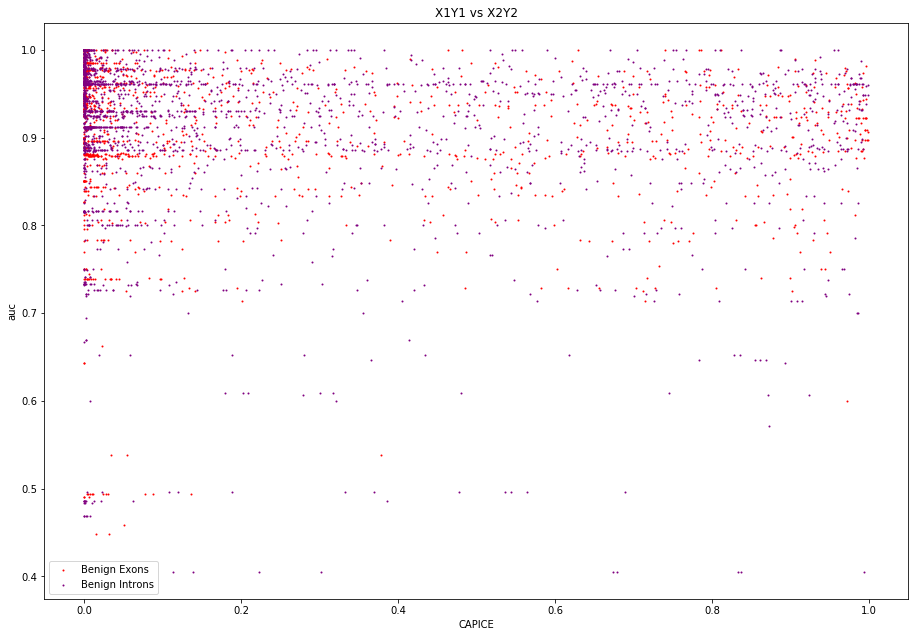


'Benign'
X is likely not normally distributed.
Y is likely not normally distributed.
The Kolmogorov-Smirnov test p-value: 1.0
Wilcoxon could not be performed, 
Using Mann-Whitney rank test p-value: 0.2530791659900159
Pearson correlation could not be performed!

'Malignant'
X is likely not normally distributed.
Y is likely not normally distributed.
The Kolmogorov-Smirnov test p-value: 0.9985101505880065
Wilcoxon could not be performed, 
Using Mann-Whitney rank test p-value: 1.3286908254119973e-101
Pearson correlation could not be performed!

'Benign Intron, Malignant Intron'
X is likely not normally distributed.
Y is likely not normally distributed.
The Kolmogorov-Smirnov test p-value: 0.9999999999886016
Wilcoxon could not be performed, 
Using Mann-Whitney rank test p-value: 0.0
Pearson correlation could not be performed!

'Benign Exon, Malignant Exon'
X is likely not normally distributed.
Y is likely not normally distributed.
The Kolmogorov-Smirnov test p-value: 0.7803459091340439
Wil

/usr/lib/python3.8/site-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [36]:
auc_exon_detailed = intronic_exonic_dataset[intronic_exonic_dataset['exonic'] == 1][['gene','capice','auc','label']]
auc_intron_detailed = intronic_exonic_dataset[intronic_exonic_dataset['exonic'] == 0][['gene','capice','auc','label']]
benign_aed = auc_exon_detailed[auc_exon_detailed['label'] == 'LB/B']
malign_aed = auc_exon_detailed[auc_exon_detailed['label'] == 'LP/P']
benign_aid = auc_intron_detailed[auc_intron_detailed['label'] == 'LB/B']
malign_aid = auc_intron_detailed[auc_intron_detailed['label'] == 'LP/P']

fig = plt.figure(figsize=(15,10))
axes = fig.add_axes([0.1,0.1,0.8,0.8])
axes.scatter(benign_aed['capice'], benign_aed['auc'], c='red', label='Benign Exons', s=1)
# axes.scatter(malign_aed['capice'], malign_aed['auc'], c='blue', label='Malign Exons', s=1)
axes.scatter(benign_aid['capice'], benign_aid['auc'], c='purple', label='Benign Introns', s=1)
# axes.scatter(malign_aid['capice'], malign_aid['auc'], c='orange', label='Malign Introns', s=1)
axes.set_xlabel("CAPICE")
axes.set_ylabel("auc")
axes.set_title("X1Y1 vs X2Y2")
axes.legend()
plt.show()
# auc_exon_detailed

print("\n'Benign'")
perform_stats(benign_aed['capice'], benign_aid['capice'])
print("\n'Malignant'")
perform_stats(malign_aed['capice'], malign_aid['capice'])
print("\n'Benign Intron, Malignant Intron'")
perform_stats(benign_aid['capice'], malign_aid['capice'])
print("\n'Benign Exon, Malignant Exon'")
perform_stats(benign_aed['capice'], malign_aed['capice'])
print("\n'Benign Intron, Malignant Exon'")
perform_stats(benign_aid['capice'], malign_aed['capice'])
print("\n'Benign Exon, Malignant Intron'")
perform_stats(benign_aed['capice'], malign_aid['capice'])
print("\n'Exons vs Introns'")
perform_stats(auc_exon_detailed['capice'], auc_intron_detailed['capice'])
# Will coxon test

In [37]:
_, lev_pexbm = stats.levene(benign_aed['auc'].dropna(), malign_aed['auc'].dropna())
if lev_pexbm >= 0.05:
    e_q_var_pexbm = False
else:
    e_q_var_pexbm = True
    
_, lev_pexinb = stats.levene(benign_aed['auc'].dropna(), benign_aid['auc'].dropna())
if lev_pexinb >= 0.05:
    e_q_var_pexinb = False
else:
    e_q_var_pexinb = True
    
_, lev_pexinm = stats.levene(malign_aed['auc'].dropna(), malign_aid['auc'].dropna())
if lev_pexinm >= 0.05:
    e_q_var_pexinm = False
else:
    e_q_var_pexinm = True
    
_, lev_pinbm = stats.levene(benign_aid['auc'].dropna(), malign_aid['auc'].dropna())
if lev_pinbm >= 0.05:
    e_q_var_pinbm = False
else:
    e_q_var_pinbm = True

t2, p_ex_bm = stats.ttest_ind(benign_aed['auc'].dropna(), malign_aed['auc'].dropna(), equal_var=e_q_var_pexbm)
t2, p_ex_in_b = stats.ttest_ind(benign_aed['auc'].dropna(), benign_aid['auc'].dropna(), equal_var=e_q_var_pexinb)
t2, p_ex_in_m = stats.ttest_ind(malign_aed['auc'].dropna(), malign_aid['auc'].dropna(), equal_var=e_q_var_pexinm)
t2, p_in_bm = stats.ttest_ind(benign_aid['auc'].dropna(), malign_aid['auc'].dropna(), equal_var=False)

print(f'Exons, benign malign: {p_ex_bm}. With lev: {e_q_var_pexbm}. \n'
     f'Exon, intron benign: {p_ex_in_b}. With lev: {e_q_var_pexbm}.\n'
     f'Exon, intron malign: {p_ex_in_m}. \n'
     f'Intron, benign malign: {p_in_bm}.')

# Test again, but in will coxon test.

Exons, benign malign: 4.106182017721228e-90. With lev: True. 
Exon, intron benign: 0.022393800189555748. With lev: True.
Exon, intron malign: 9.706396170816319e-15. 
Intron, benign malign: 5.701290472292696e-73.


In [38]:
# Are they different? Let's student t test it!

auc_exon2 = auc_exon['auc'].dropna()
auc_intron2 = auc_intron['auc'].dropna()

perform_stats(auc_exon2,auc_intron2)

t2, p2 = stats.ttest_ind(auc_exon2,auc_intron2, equal_var=False)
if p2 >= 0.05:
    print(f'We fail to reject H0 hypothesis. P = {p2}')
else:
    print(f'We have statistical power to reject H0 hypothesis. P = {p2}')


X is likely not normally distributed.
Y is likely not normally distributed.
The Kolmogorov-Smirnov test p-value: 1.0
Wilcoxon could not be performed, 
Using Mann-Whitney rank test p-value: 2.325699361498863e-20
Pearson correlation could not be performed!
We fail to reject H0 hypothesis. P = 0.5044278321291654


In [39]:
intronic_exonic_dataset['n_test'] = 0
intronic_exonic_dataset['n_test_malign'] = 0
reset_timer = time.time()
done_rows = 0
total_rows = intronic_exonic_dataset.shape[0]
for row in intronic_exonic_dataset.iterrows():
    timer_ifl = time.time()
    if timer_ifl - reset_timer > 10:
        print(f"Still running, done: {round(done_rows / total_rows * 100, ndigits=2)}&")
        reset_timer = time.time()
    index = row[0]
    row = row[1]
    gene_req = row['gene']
#     print(data[data['Gene'] == gene_req]['n_snvs'].shape)
    if data[data['Gene'] == gene_req]['n_snvs'].shape[0] != 1:
        n_test_gene = np.NaN
        n_malign_train = np.NaN
    else:
        n_test_gene = data[data['Gene'] == gene_req]['n_snvs'].item()
        n_malign_train = data[data['Gene'] == gene_req]['N_malign'].item()
    intronic_exonic_dataset.loc[index, 'n_test'] = n_test_gene
    intronic_exonic_dataset.loc[index, 'n_test_malign'] = n_malign_train
    done_rows += 1

intronic_exonic_dataset

Still running, done: 12.99&
Still running, done: 28.24&
Still running, done: 43.53&
Still running, done: 58.5&
Still running, done: 73.14&
Still running, done: 88.48&


,#Chrom,Pos,Ref,Alt,max_AF,Consequence,label,revel,clinpred,sift,provean,PHRED,fathmm_score,capice,ponp2,gene,auc,exonic,n_test,n_test_malign
0,21,33974174,C,G,0.000058,STOP_LOST,LB/B,NaN,NaN,NaN,NaN,15.050,NaN,0.003275,NaN,C21orf59,NaN,1,19.0,0.0
1,21,33974278,C,CA,0.000045,FRAME_SHIFT,LB/B,NaN,NaN,NaN,NaN,35.000,NaN,0.304741,NaN,C21orf59,NaN,1,19.0,0.0
2,X,99661625,G,C,0.000037,SYNONYMOUS,LB/B,NaN,NaN,0.00,-0.00,0.806,NaN,0.000075,NaN,PCDH19,0.906593,1,177.0,86.0
3,X,99663098,G,GT,0.000013,STOP_GAINED,LB/B,NaN,NaN,NaN,NaN,35.000,NaN,0.998694,NaN,PCDH19,0.906593,1,177.0,86.0
4,X,99662275,C,G,0.000212,NON_SYNONYMOUS,LB/B,0.527,NaN,0.95,2.51,27.000,NaN,0.863940,0.436,PCDH19,0.906593,1,177.0,86.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10540,22,36662041,AATAATT,A,0.141400,INFRAME,LP/P,NaN,NaN,NaN,8.98,7.508,NaN,0.004829,NaN,APOL1,NaN,1,81.0,0.0
10541,2,31754497,T,C,0.000033,NONCODING_CHANGE,LP/P,NaN,NaN,NaN,NaN,19.790,0.951270,0.918898,NaN,SRD5A2,0.921053,0,30.0,19.0
10542,2,31754393,C,T,0.000000,NONCODING_CHANGE,LP/P,NaN,NaN,NaN,NaN,21.700,NaN,0.985064,NaN,SRD5A2,0.921053,0,30.0,19.0
10543,2,31758741,T,C,0.000200,NONCODING_CHANGE,LP/P,NaN,NaN,NaN,NaN,20.800,0.912937,0.474717,NaN,SRD5A2,0.921053,0,30.0,19.0


In [40]:
intronic_exonic_dataset[intronic_exonic_dataset['n_test'].isna()]

# Gene is NaN and label is only LB/B. Accidental slip ins or variants in regularitory areas?

,#Chrom,Pos,Ref,Alt,max_AF,Consequence,label,revel,clinpred,sift,provean,PHRED,fathmm_score,capice,ponp2,gene,auc,exonic,n_test,n_test_malign
2174,8,133492864,G,A,0.003077,5PRIME_UTR,LB/B,NaN,NaN,NaN,NaN,17.320,NaN,0.000113,NaN,NaN,NaN,0,NaN,NaN
2175,12,56583325,CCCGCCGCCTCCCGCCGCCGCGG,C,0.000442,5PRIME_UTR,LB/B,NaN,NaN,NaN,NaN,16.160,NaN,0.004680,NaN,NaN,NaN,0,NaN,NaN
2176,1,231559243,C,T,0.001601,5PRIME_UTR,LB/B,NaN,NaN,NaN,NaN,5.848,NaN,0.000290,NaN,NaN,NaN,0,NaN,NaN
2177,3,45430178,C,A,0.000000,REGULATORY,LB/B,NaN,NaN,NaN,NaN,12.570,NaN,0.000451,NaN,NaN,NaN,0,NaN,NaN
2178,9,116163571,G,GG,0.000000,REGULATORY,LB/B,NaN,NaN,NaN,NaN,13.960,NaN,0.000968,NaN,NaN,NaN,0,NaN,NaN
2179,6,163148775,A,G,0.000125,REGULATORY,LB/B,NaN,NaN,NaN,NaN,10.020,NaN,0.000113,NaN,NaN,NaN,0,NaN,NaN
2180,4,1901007,C,T,0.000000,REGULATORY,LB/B,NaN,NaN,NaN,NaN,5.730,NaN,0.000068,NaN,NaN,NaN,0,NaN,NaN
2181,15,63349381,CC,C,0.000000,INTRONIC,LB/B,NaN,NaN,NaN,NaN,6.580,NaN,0.001253,NaN,NaN,NaN,0,NaN,NaN
2182,5,88178755,A,T,0.000115,UPSTREAM,LB/B,NaN,NaN,NaN,NaN,22.500,0.844183,0.037625,NaN,NaN,NaN,0,NaN,NaN
2183,13,22245256,C,T,0.001812,UPSTREAM,LB/B,NaN,NaN,NaN,NaN,22.500,NaN,0.002467,NaN,NaN,NaN,0,NaN,NaN


In [41]:
list_of_plotted_genes = list(m_cat_filtered_usable['Gene'])

In [42]:
# test_filter1 = intronic_exonic_dataset[intronic_exonic_dataset['gene'] in list_of_plotted_genes]
test_filter1 = pd.DataFrame(columns=intronic_exonic_dataset.columns)
reset_timer = time.time()
done_rows = 0
total_rows = intronic_exonic_dataset.shape[0]
for row in intronic_exonic_dataset.iterrows():
    time_ifl = time.time()
    if time_ifl - reset_timer > 10:
        print(f"Still running, done {round(done_rows / total_rows * 100, ndigits=2)}%.")
        reset_timer = time.time()
    row = row[1]
#     print(row['gene'])
#     break
    if row['gene'] in list_of_plotted_genes:
#         print(f"Appending row: {row}")
        test_filter1 = test_filter1.append(row)
    done_rows += 1


        


Still running, done 13.02%.
Still running, done 23.11%.
Still running, done 33.81%.
Still running, done 50.36%.
Still running, done 64.14%.
Still running, done 73.69%.
Still running, done 84.25%.
Still running, done 90.39%.
Still running, done 95.7%.


In [43]:
test_filter1 = test_filter1.astype({'n_test':'int32','n_test_malign':'int32'})

test_filter1.sort_values(by=['n_test', 'n_test_malign', 'auc', 'capice'], ascending=False)

,#Chrom,Pos,Ref,Alt,max_AF,Consequence,label,revel,clinpred,sift,provean,PHRED,fathmm_score,capice,ponp2,gene,auc,exonic,n_test,n_test_malign
535,2,179481608,AG,A,0.000000,FRAME_SHIFT,LP/P,NaN,NaN,NaN,NaN,41.0,NaN,0.996111,NaN,TTN,0.960966,0,4575,659
512,2,179469476,AT,A,0.000000,FRAME_SHIFT,LP/P,NaN,NaN,NaN,NaN,45.0,NaN,0.996079,NaN,TTN,0.960966,0,4575,659
414,2,179428493,AG,A,0.000009,FRAME_SHIFT,LB/B,NaN,NaN,NaN,NaN,57.0,NaN,0.992506,NaN,TTN,0.960966,0,4575,659
494,2,179449659,GA,G,0.000000,FRAME_SHIFT,LP/P,NaN,NaN,NaN,NaN,49.0,NaN,0.992341,NaN,TTN,0.960966,0,4575,659
357,2,179431247,TA,T,0.000030,FRAME_SHIFT,LB/B,NaN,NaN,NaN,NaN,59.0,NaN,0.991003,NaN,TTN,0.960966,0,4575,659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8627,1,165697319,C,T,0.003311,NON_SYNONYMOUS,LB/B,0.221,0.279363,0.986,2.24,28.4,NaN,0.137733,0.47,TMCO1,0.854167,0,14,6
10280,9,100447259,G,A,0.000065,STOP_GAINED,LP/P,NaN,NaN,NaN,NaN,35.0,NaN,0.683882,NaN,XPA,1.000000,0,13,6
10279,9,100455945,A,ATT,0.000000,FRAME_SHIFT,LP/P,NaN,NaN,NaN,NaN,34.0,NaN,0.605081,NaN,XPA,1.000000,0,13,6
7529,14,57268651,GGTACCCATGGG,G,0.000000,FRAME_SHIFT,LP/P,NaN,NaN,NaN,NaN,35.0,NaN,0.973545,NaN,OTX2,0.785714,1,13,6


In [44]:
test_filter1[test_filter1['gene'] == 'OTX2']

,#Chrom,Pos,Ref,Alt,max_AF,Consequence,label,revel,clinpred,sift,provean,PHRED,fathmm_score,capice,ponp2,gene,auc,exonic,n_test,n_test_malign
7528,14,57272111,TA,T,0.0,FRAME_SHIFT,LB/B,NaN,NaN,NaN,NaN,18.2,NaN,0.877414,NaN,OTX2,0.785714,1,13,6
7529,14,57268651,GGTACCCATGGG,G,0.0,FRAME_SHIFT,LP/P,NaN,NaN,NaN,NaN,35.0,NaN,0.973545,NaN,OTX2,0.785714,1,13,6


In [45]:
test_filter1.sort_values(by=['auc'],ascending=True)['gene'].unique()

array(['ARID2', 'EBF3', 'RPL5', 'DDX3X', 'ZMYND11', 'PHIP', 'PUF60',
       'PDE11A', 'VPS33B', 'NFIX', 'PRSS1', 'BCL11A', 'TRIP12', 'EDA',
       'GATAD2B', 'OTX2', 'CHD8', 'FOXL2', 'NAA10', 'HNF4A', 'POGZ',
       'CLTC', 'PPM1D', 'MC4R', 'PHF6', 'KDM6A', 'DLL4', 'DCX', 'USP9X',
       'CCM2', 'SPAG1', 'DOCK7', 'SIX3', 'WAC', 'TUBB2A', 'ADNP', 'RBM10',
       'GRHL3', 'SON', 'NR0B1', 'TTR', 'HNF1A', 'TRPV4', 'CLCN4', 'CLCN2',
       'TUBB2B', 'GLI2', 'FOXP3', 'CTCF', 'PDCD10', 'PAX6', 'KMT2C',
       'TCF12', 'MYH2', 'FUCA1', 'ABCD1', 'ADA', 'TMCO1', 'CTNNB1',
       'SHANK3', 'TNNC1', 'HSPB1', 'CAV3', 'COL9A3', 'SOX11', 'POLK',
       'EXT1', 'RAD21', 'CACNA1C', 'KDM5C', 'PRPH2', 'SMC3', 'KAT6A',
       'PSEN1', 'LRP6', 'G6PD', 'EFTUD2', 'PHEX', 'NIPBL', 'GALT', 'EXT2',
       'CYP27A1', 'GLUD1', 'IRF6', 'KCNH1', 'TMEM216', 'ASXL3', 'GBA',
       'F9', 'ASXL1', 'ELANE', 'LZTR1', 'KMT2B', 'MAP2K1', 'SMCHD1',
       'PRPF31', 'ACTN2', 'SMARCA2', 'SATB2', 'FOXG1', 'RAD50', 'CREBBP',
  

In [46]:
temp2 = test_filter1[test_filter1['auc'].notnull()]
temp2.sort_values(by=['auc'],ascending=True)['gene'].unique()

array(['ARID2', 'EBF3', 'RPL5', 'DDX3X', 'ZMYND11', 'PHIP', 'PUF60',
       'PDE11A', 'VPS33B', 'NFIX', 'PRSS1', 'BCL11A', 'TRIP12', 'EDA',
       'GATAD2B', 'OTX2', 'CHD8', 'FOXL2', 'NAA10', 'HNF4A', 'POGZ',
       'CLTC', 'PPM1D', 'MC4R', 'PHF6', 'KDM6A', 'DLL4', 'DCX', 'USP9X',
       'CCM2', 'SPAG1', 'DOCK7', 'SIX3', 'WAC', 'TUBB2A', 'ADNP', 'RBM10',
       'GRHL3', 'SON', 'NR0B1', 'TTR', 'HNF1A', 'TRPV4', 'CLCN4', 'CLCN2',
       'TUBB2B', 'GLI2', 'FOXP3', 'CTCF', 'PDCD10', 'PAX6', 'KMT2C',
       'TCF12', 'MYH2', 'FUCA1', 'ABCD1', 'ADA', 'TMCO1', 'CTNNB1',
       'SHANK3', 'TNNC1', 'HSPB1', 'CAV3', 'COL9A3', 'SOX11', 'POLK',
       'EXT1', 'RAD21', 'CACNA1C', 'KDM5C', 'PRPH2', 'SMC3', 'KAT6A',
       'PSEN1', 'LRP6', 'G6PD', 'EFTUD2', 'PHEX', 'NIPBL', 'GALT', 'EXT2',
       'CYP27A1', 'GLUD1', 'IRF6', 'KCNH1', 'TMEM216', 'ASXL3', 'GBA',
       'F9', 'ASXL1', 'ELANE', 'LZTR1', 'KMT2B', 'MAP2K1', 'SMCHD1',
       'PRPF31', 'ACTN2', 'SMARCA2', 'SATB2', 'FOXG1', 'RAD50', 'CREBBP',
  

In [47]:
temp2[temp2['gene'] == 'PHIP']

,#Chrom,Pos,Ref,Alt,max_AF,Consequence,label,revel,clinpred,sift,provean,PHRED,fathmm_score,capice,ponp2,gene,auc,exonic,n_test,n_test_malign
6277,6,79707979,A,T,0.000004,STOP_GAINED,LB/B,NaN,NaN,NaN,NaN,39.0,0.071601,0.908600,NaN,PHIP,0.714286,0,59,17
6278,6,79656530,G,C,0.000000,STOP_GAINED,LB/B,NaN,NaN,NaN,NaN,43.0,NaN,0.405693,NaN,PHIP,0.714286,0,59,17
6279,6,79752583,G,A,0.000000,STOP_GAINED,LB/B,NaN,NaN,NaN,NaN,37.0,NaN,0.900301,NaN,PHIP,0.714286,0,59,17
6280,6,79724886,AG,A,0.000009,FRAME_SHIFT,LB/B,NaN,NaN,NaN,NaN,35.0,NaN,0.725935,NaN,PHIP,0.714286,0,59,17
6281,6,79655803,TG,T,0.000009,FRAME_SHIFT,LB/B,NaN,NaN,NaN,NaN,27.8,NaN,0.914858,NaN,PHIP,0.714286,0,59,17
6282,6,79724881,ACT,A,0.000009,FRAME_SHIFT,LB/B,NaN,NaN,NaN,NaN,34.0,NaN,0.577542,NaN,PHIP,0.714286,0,59,17
6283,6,79707130,CCTGGCTACACCAG,C,0.000009,FRAME_SHIFT,LB/B,NaN,NaN,NaN,NaN,34.0,NaN,0.808567,NaN,PHIP,0.714286,0,59,17
6284,6,79655915,AAT,A,0.000000,FRAME_SHIFT,LP/P,NaN,NaN,NaN,NaN,33.0,NaN,0.859248,NaN,PHIP,0.714286,0,59,17
6285,6,79692624,CTTCT,C,0.000000,FRAME_SHIFT,LP/P,NaN,NaN,NaN,NaN,34.0,NaN,0.807910,NaN,PHIP,0.714286,0,59,17
6286,6,79700682,G,GTC,0.000000,FRAME_SHIFT,LP/P,NaN,NaN,NaN,NaN,35.0,NaN,0.135553,NaN,PHIP,0.714286,0,59,17


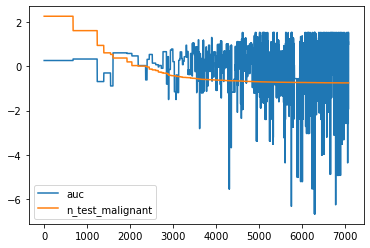

In [87]:

temp2_plot = calc_z_scores(np.array(temp2[['auc','n_test_malign']].sort_values(by=['n_test_malign'], ascending=False)))
temp2_plot_index = np.arange(temp2_plot.shape[0])
plt.plot(temp2_plot_index, temp2_plot[:,0], label='auc')
plt.plot(temp2_plot_index, temp2_plot[:,1], label='n_test_malignant')
plt.legend()
plt.show()

In [49]:
# Intronic Exonic DataSet Different Labels
iedsdl = intronic_exonic_dataset.copy()
iedsdl['label'] = iedsdl['label'].replace({"LB/B":0,"LP/P":1})
iedsdl


,#Chrom,Pos,Ref,Alt,max_AF,Consequence,label,revel,clinpred,sift,provean,PHRED,fathmm_score,capice,ponp2,gene,auc,exonic,n_test,n_test_malign
0,21,33974174,C,G,0.000058,STOP_LOST,0,NaN,NaN,NaN,NaN,15.050,NaN,0.003275,NaN,C21orf59,NaN,1,19.0,0.0
1,21,33974278,C,CA,0.000045,FRAME_SHIFT,0,NaN,NaN,NaN,NaN,35.000,NaN,0.304741,NaN,C21orf59,NaN,1,19.0,0.0
2,X,99661625,G,C,0.000037,SYNONYMOUS,0,NaN,NaN,0.00,-0.00,0.806,NaN,0.000075,NaN,PCDH19,0.906593,1,177.0,86.0
3,X,99663098,G,GT,0.000013,STOP_GAINED,0,NaN,NaN,NaN,NaN,35.000,NaN,0.998694,NaN,PCDH19,0.906593,1,177.0,86.0
4,X,99662275,C,G,0.000212,NON_SYNONYMOUS,0,0.527,NaN,0.95,2.51,27.000,NaN,0.863940,0.436,PCDH19,0.906593,1,177.0,86.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10540,22,36662041,AATAATT,A,0.141400,INFRAME,1,NaN,NaN,NaN,8.98,7.508,NaN,0.004829,NaN,APOL1,NaN,1,81.0,0.0
10541,2,31754497,T,C,0.000033,NONCODING_CHANGE,1,NaN,NaN,NaN,NaN,19.790,0.951270,0.918898,NaN,SRD5A2,0.921053,0,30.0,19.0
10542,2,31754393,C,T,0.000000,NONCODING_CHANGE,1,NaN,NaN,NaN,NaN,21.700,NaN,0.985064,NaN,SRD5A2,0.921053,0,30.0,19.0
10543,2,31758741,T,C,0.000200,NONCODING_CHANGE,1,NaN,NaN,NaN,NaN,20.800,0.912937,0.474717,NaN,SRD5A2,0.921053,0,30.0,19.0


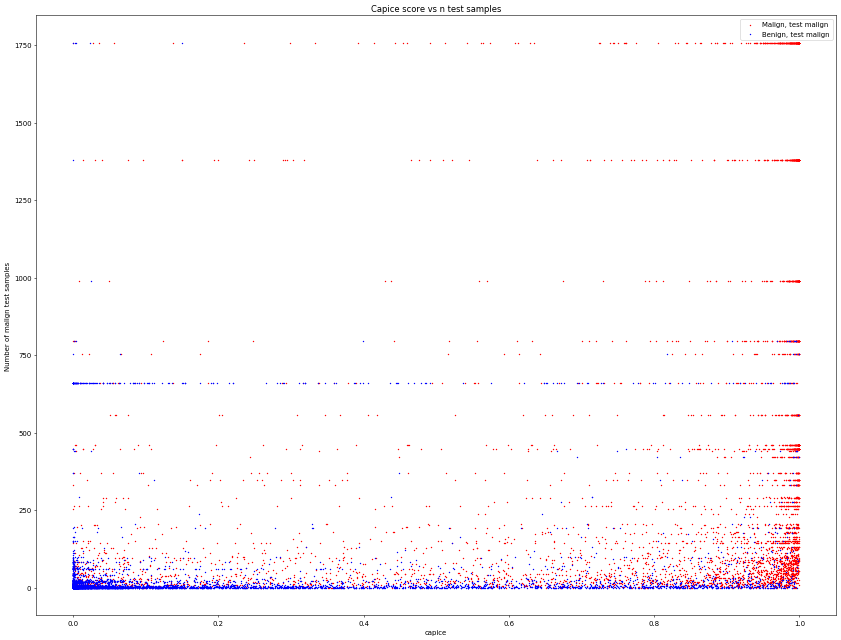

In [50]:
tot_malign = iedsdl['n_test_malign'].sum()
# iedsdl['p_n_test_malign'] = iedsdl['n_test_malign'].apply(lambda x: x/tot_malign*1000)
iedsdl_malign = iedsdl[iedsdl['label'] == 1]
iedsdl_benign = iedsdl[iedsdl['label'] == 0]
# print(iedsdl.sort_values(by=['n_test_malign'], ascending=False))
fig = plt.figure(figsize=(20,15), dpi=50)
axes = fig.add_axes([0.1,0.1,0.8,0.8])
axes.scatter(iedsdl_malign['capice'], iedsdl_malign['n_test_malign'], c='red', label='Malign, test malign', s=1)
axes.scatter(iedsdl_benign['capice'], iedsdl_benign['n_test_malign'], c='blue', label='Benign, test malign', s=1)
# axes.scatter(iedsdl_malign['capice'], iedsdl_malign['n_test'], c='purple', label='Malign, full', s=1)
# axes.scatter(iedsdl_benign['capice'], iedsdl_benign['n_test'], c='orange', label='Benign, full', s=1)

axes.set_xlabel("capice")
axes.set_ylabel("Number of malign test samples")
axes.set_title("Capice score vs n test samples")
axes.legend()
plt.show()

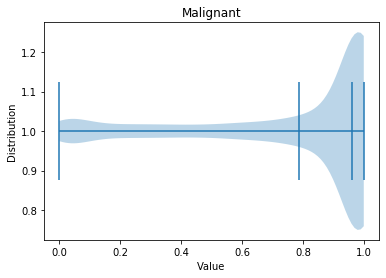

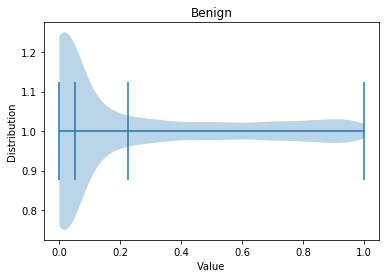

In [51]:
capice_per_malign = np.array(iedsdl[iedsdl['label'] == 1][['capice']])
capice_per_benign = np.array(iedsdl[iedsdl['label'] == 0][['capice']])

plt.violinplot(capice_per_malign,vert=False,showmeans=True,showextrema=True,showmedians=True)
plt.title('Malignant')
plt.xlabel('Value')
plt.ylabel("Distribution")
plt.show()
plt.violinplot(capice_per_benign,vert=False,showmeans=True,showextrema=True,showmedians=True)
plt.title('Benign')
plt.xlabel('Value')
plt.ylabel("Distribution")
plt.show()

In [52]:
temp3 = iedsdl[iedsdl['n_test_malign'].notnull()]
temp3.sort_values(by=['n_test_malign'])

,#Chrom,Pos,Ref,Alt,max_AF,Consequence,label,revel,clinpred,sift,provean,PHRED,fathmm_score,capice,ponp2,gene,auc,exonic,n_test,n_test_malign
0,21,33974174,C,G,0.000058,STOP_LOST,0,NaN,NaN,NaN,NaN,15.05,NaN,0.003275,NaN,C21orf59,NaN,1,19.0,0.0
5348,20,2377257,G,A,0.000009,STOP_GAINED,0,NaN,NaN,NaN,NaN,49.00,NaN,0.088299,NaN,TGM6,NaN,1,178.0,0.0
5349,20,2380225,C,T,0.000144,STOP_GAINED,0,NaN,NaN,NaN,NaN,37.00,0.172360,0.007464,NaN,TGM6,NaN,1,178.0,0.0
5350,20,2377268,C,T,0.000030,STOP_GAINED,0,NaN,NaN,NaN,NaN,46.00,NaN,0.006441,NaN,TGM6,NaN,1,178.0,0.0
5351,20,2411129,T,A,0.000009,STOP_GAINED,0,NaN,NaN,NaN,NaN,39.00,0.116146,0.008311,NaN,TGM6,NaN,1,178.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2428,13,32945164,AT,A,0.000000,FRAME_SHIFT,1,NaN,NaN,NaN,NaN,26.20,NaN,0.997950,NaN,BRCA2,0.946305,1,2973.0,1756.0
2427,13,32903615,CA,C,0.000000,FRAME_SHIFT,1,NaN,NaN,NaN,NaN,24.80,NaN,0.999726,NaN,BRCA2,0.946305,1,2973.0,1756.0
2426,13,32911661,AAG,A,0.000000,FRAME_SHIFT,1,NaN,NaN,NaN,NaN,25.90,NaN,0.999866,NaN,BRCA2,0.946305,1,2973.0,1756.0
3036,13,32968863,C,A,0.000000,STOP_GAINED,1,NaN,NaN,NaN,NaN,36.00,NaN,0.886732,NaN,BRCA2,0.946305,1,2973.0,1756.0


In [53]:
# Gene annotation:
# Dominant/Recessief?
# Ziektebeeld (maybe)?
# Kolmogorov-Smirnov test over distributions over capice in pathogenic vs benign
# Discussie note: varianten kunnen verkeerd gelabeld zijn!
# Model getrained genoom breed, uitkijken met uitspraken over genen en varianten.
# Meer test train/test runs met extra/minder variabelen.


In [54]:
cgd_txt = pd.read_csv("/home/rjsietsma/Documents/School/Master_DSLS/Final_Thesis/Initial_Data_exploration/CGD.txt", sep='\t', header=0)
cgd_txt

,#GENE,HGNC ID,ENTREZ GENE ID,CONDITION,INHERITANCE,AGE GROUP,ALLELIC CONDITIONS,MANIFESTATION CATEGORIES,INTERVENTION CATEGORIES,COMMENTS,INTERVENTION/RATIONALE,REFERENCES
0,A2M,7,2,Alpha-2-macroglobulin deficiency,AD,NaN,NaN,General,General,Variants have been implicated in pulmonary dis...,The clinical consequences of variants are unclear,94459; 2475424; 1370808
1,A2ML1,23336,144568,"Otitis media, susceptibility to",AD,Pediatric,NaN,Allergy/Immunology/Infectious,Allergy/Immunology/Infectious,NaN,Individuals may have increased susceptibility ...,26121085
2,A4GALT,18149,53947,"Blood group, P system",BG,Pediatric,NaN,Hematologic,Hematologic,NaN,Variants associated with a blood group may be ...,10993874
3,AAAS,13666,8086,Achalasia-addisonianism-alacrimia syndrome,AR,Pediatric,NaN,Dermatologic; Endocrine; Gastrointestinal; Neu...,Endocrine,NaN,Surveillance and treatment/preventive measures...,78049; 6243664; 3565479; 1537368; 8006362; 789...
4,AAGAB,25662,79719,"Keratoderma, palmoplantar, punctate type IA",AD,NaN,NaN,Dermatologic,General,NaN,Genetic knowledge may be beneficial related to...,23000146; 23064416
...,...,...,...,...,...,...,...,...,...,...,...,...
3995,ZNHIT3,12309,9326,PEHO syndrome,AR,NaN,NaN,Craniofacial; Dermatologic; Neurologic,General,NaN,Genetic knowledge may be beneficial related to...,28335020
3996,ZP1,13187,22917,Oocyte maturation defect 1,AR,NaN,NaN,Obstetric,General,NaN,Genetic knowledge may be beneficial related to...,24670168
3997,ZP2,13188,7783,Oocyte maturation defect 6,AR,NaN,NaN,Obstetric,General,NaN,Genetic knowledge may be beneficial related to...,29895852
3998,ZP3,13189,7784,Oocyte maturation defect 3,AD,NaN,NaN,Obstetric,General,NaN,Genetic knowledge may be beneficial related to...,28886344


In [55]:
inheritence_ieds = pd.merge(iedsdl, cgd_txt[['#GENE','INHERITANCE','AGE GROUP']], left_on=['gene'], right_on=['#GENE'])
inheritence_ieds = inheritence_ieds.drop(['#GENE'], axis=1)
inheritence_ieds

,#Chrom,Pos,Ref,Alt,max_AF,Consequence,label,revel,clinpred,sift,...,fathmm_score,capice,ponp2,gene,auc,exonic,n_test,n_test_malign,INHERITANCE,AGE GROUP
0,X,99661625,G,C,0.000037,SYNONYMOUS,0,NaN,NaN,0.000,...,NaN,0.000075,NaN,PCDH19,0.906593,1,177.0,86.0,XL,NaN
1,X,99663098,G,GT,0.000013,STOP_GAINED,0,NaN,NaN,NaN,...,NaN,0.998694,NaN,PCDH19,0.906593,1,177.0,86.0,XL,NaN
2,X,99662275,C,G,0.000212,NON_SYNONYMOUS,0,0.527,NaN,0.950,...,NaN,0.863940,0.436,PCDH19,0.906593,1,177.0,86.0,XL,NaN
3,X,99657670,A,ACCCAG,0.000000,FRAME_SHIFT,1,NaN,NaN,NaN,...,NaN,0.687628,NaN,PCDH19,0.906593,1,177.0,86.0,XL,NaN
4,17,29509638,C,T,0.000000,SYNONYMOUS,0,NaN,NaN,0.647,...,NaN,0.001511,NaN,NF1,0.922413,1,1581.0,795.0,AD,Pediatric
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9304,X,19368150,A,AAGA,0.000000,INFRAME,1,NaN,NaN,NaN,...,NaN,0.121208,NaN,PDHA1,0.894737,1,73.0,35.0,XL,Pediatric
9305,2,31754497,T,C,0.000033,NONCODING_CHANGE,1,NaN,NaN,NaN,...,0.951270,0.918898,NaN,SRD5A2,0.921053,0,30.0,19.0,AR,Pediatric
9306,2,31754393,C,T,0.000000,NONCODING_CHANGE,1,NaN,NaN,NaN,...,NaN,0.985064,NaN,SRD5A2,0.921053,0,30.0,19.0,AR,Pediatric
9307,2,31758741,T,C,0.000200,NONCODING_CHANGE,1,NaN,NaN,NaN,...,0.912937,0.474717,NaN,SRD5A2,0.921053,0,30.0,19.0,AR,Pediatric


In [56]:
# AD = autosomal dominant
# AR = autosomal recessive
# XL = x linked
# Digenic = simultanious mutation in different genes
# BG = blood group
inheritence_ieds['ad'] = 0
inheritence_ieds['ar'] = 0
inheritence_ieds['xl'] = 0
inheritence_ieds['digenic'] = 0
inheritence_ieds['bg'] = 0
inheritence_ieds['INHERITANCE'] = inheritence_ieds['INHERITANCE'].replace({"XL (involving both OPN1 genes)":"XL"})


In [57]:
reset_timer = time.time()
done_rows = 0
total_rows = inheritence_ieds.shape[0]
for row in inheritence_ieds.iterrows():
    time_ifl = time.time()
    if time_ifl - reset_timer > 10:
        print(f"I'm still running, done: {round(done_rows / total_rows * 100, ndigits=2)}%")
        reset_timer = time.time()
    index = row[0]
    row = row[1]
    inheritance = row['INHERITANCE'].strip()
    if isinstance(inheritance, str):
        inheritance = inheritance.split("/")
        for marker in inheritance:
            if marker == "AD":
                inheritence_ieds.loc[index, 'ad'] = 1
            if marker == "AR":
                inheritence_ieds.loc[index, 'ar'] = 1
            if marker == "XL":
                inheritence_ieds.loc[index, 'xl'] = 1
            if marker == "Digenic":
                inheritence_ieds.loc[index, 'digenic'] = 1
            if marker == "BG":
                inheritence_ieds.loc[index, 'bg'] = 1
    done_rows += 1
inheritence_ieds = inheritence_ieds.drop('INHERITANCE', axis=1)

In [58]:
inheritence_ieds

,#Chrom,Pos,Ref,Alt,max_AF,Consequence,label,revel,clinpred,sift,...,auc,exonic,n_test,n_test_malign,AGE GROUP,ad,ar,xl,digenic,bg
0,X,99661625,G,C,0.000037,SYNONYMOUS,0,NaN,NaN,0.000,...,0.906593,1,177.0,86.0,NaN,0,0,1,0,0
1,X,99663098,G,GT,0.000013,STOP_GAINED,0,NaN,NaN,NaN,...,0.906593,1,177.0,86.0,NaN,0,0,1,0,0
2,X,99662275,C,G,0.000212,NON_SYNONYMOUS,0,0.527,NaN,0.950,...,0.906593,1,177.0,86.0,NaN,0,0,1,0,0
3,X,99657670,A,ACCCAG,0.000000,FRAME_SHIFT,1,NaN,NaN,NaN,...,0.906593,1,177.0,86.0,NaN,0,0,1,0,0
4,17,29509638,C,T,0.000000,SYNONYMOUS,0,NaN,NaN,0.647,...,0.922413,1,1581.0,795.0,Pediatric,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9304,X,19368150,A,AAGA,0.000000,INFRAME,1,NaN,NaN,NaN,...,0.894737,1,73.0,35.0,Pediatric,0,0,1,0,0
9305,2,31754497,T,C,0.000033,NONCODING_CHANGE,1,NaN,NaN,NaN,...,0.921053,0,30.0,19.0,Pediatric,0,1,0,0,0
9306,2,31754393,C,T,0.000000,NONCODING_CHANGE,1,NaN,NaN,NaN,...,0.921053,0,30.0,19.0,Pediatric,0,1,0,0,0
9307,2,31758741,T,C,0.000200,NONCODING_CHANGE,1,NaN,NaN,NaN,...,0.921053,0,30.0,19.0,Pediatric,0,1,0,0,0


In [59]:
# TODO: make capice vs auc plot on every 

# Note: quote about boosting a machine learning algorithm:
# "When nothing works, boosting does." - Marion Dam, 2019

In [60]:
inheritence_ieds['pred_patho'] = 0
inheritence_ieds.loc[inheritence_ieds[inheritence_ieds['capice'] > 0.02].index, 'pred_patho'] = 1
inheritence_ieds[['label','capice','pred_patho']]

,label,capice,pred_patho
0,0,0.000075,0
1,0,0.998694,1
2,0,0.863940,1
3,1,0.687628,1
4,0,0.001511,0
...,...,...,...
9304,1,0.121208,1
9305,1,0.918898,1
9306,1,0.985064,1
9307,1,0.474717,1


In [61]:
inheritence_ieds.columns

Index(['#Chrom', 'Pos', 'Ref', 'Alt', 'max_AF', 'Consequence', 'label',
       'revel', 'clinpred', 'sift', 'provean', 'PHRED', 'fathmm_score',
       'capice', 'ponp2', 'gene', 'auc', 'exonic', 'n_test', 'n_test_malign',
       'AGE GROUP', 'ad', 'ar', 'xl', 'digenic', 'bg', 'pred_patho'],
      dtype='object')

# TODO 10-3-2019
- Is intronic / exonic dataset valid?
    - Future plan to look into
- Merge data omim and cgd
- GAVIN well performing genes vs CAPICE wel performing genes (or inverted)
- Inverted CADD and CAPICE scores
- Missing features for bad performing SNV's
- Look into PLI genes
- Look into genes that are not clinical
- Gain of function dataset?
- Transcript expression aware annotation improves rare variant discovery and interpretation (lookup)
- Ask Patrick Deelen to add me to the FrankeSwertz research group for a presentation on the research of CAPICE.
- Get added to GCC cluster for CAPICE data.
    - Mail sent
- Perform wilcoxon tests
    - Done
- Make planning

![Gantt](img/Gantt_Chart2.png)

- Share project research proposal
- Make Z-scores instead of log normalized high differences


Percentage of unanimous decision making: 51.616715006982496%


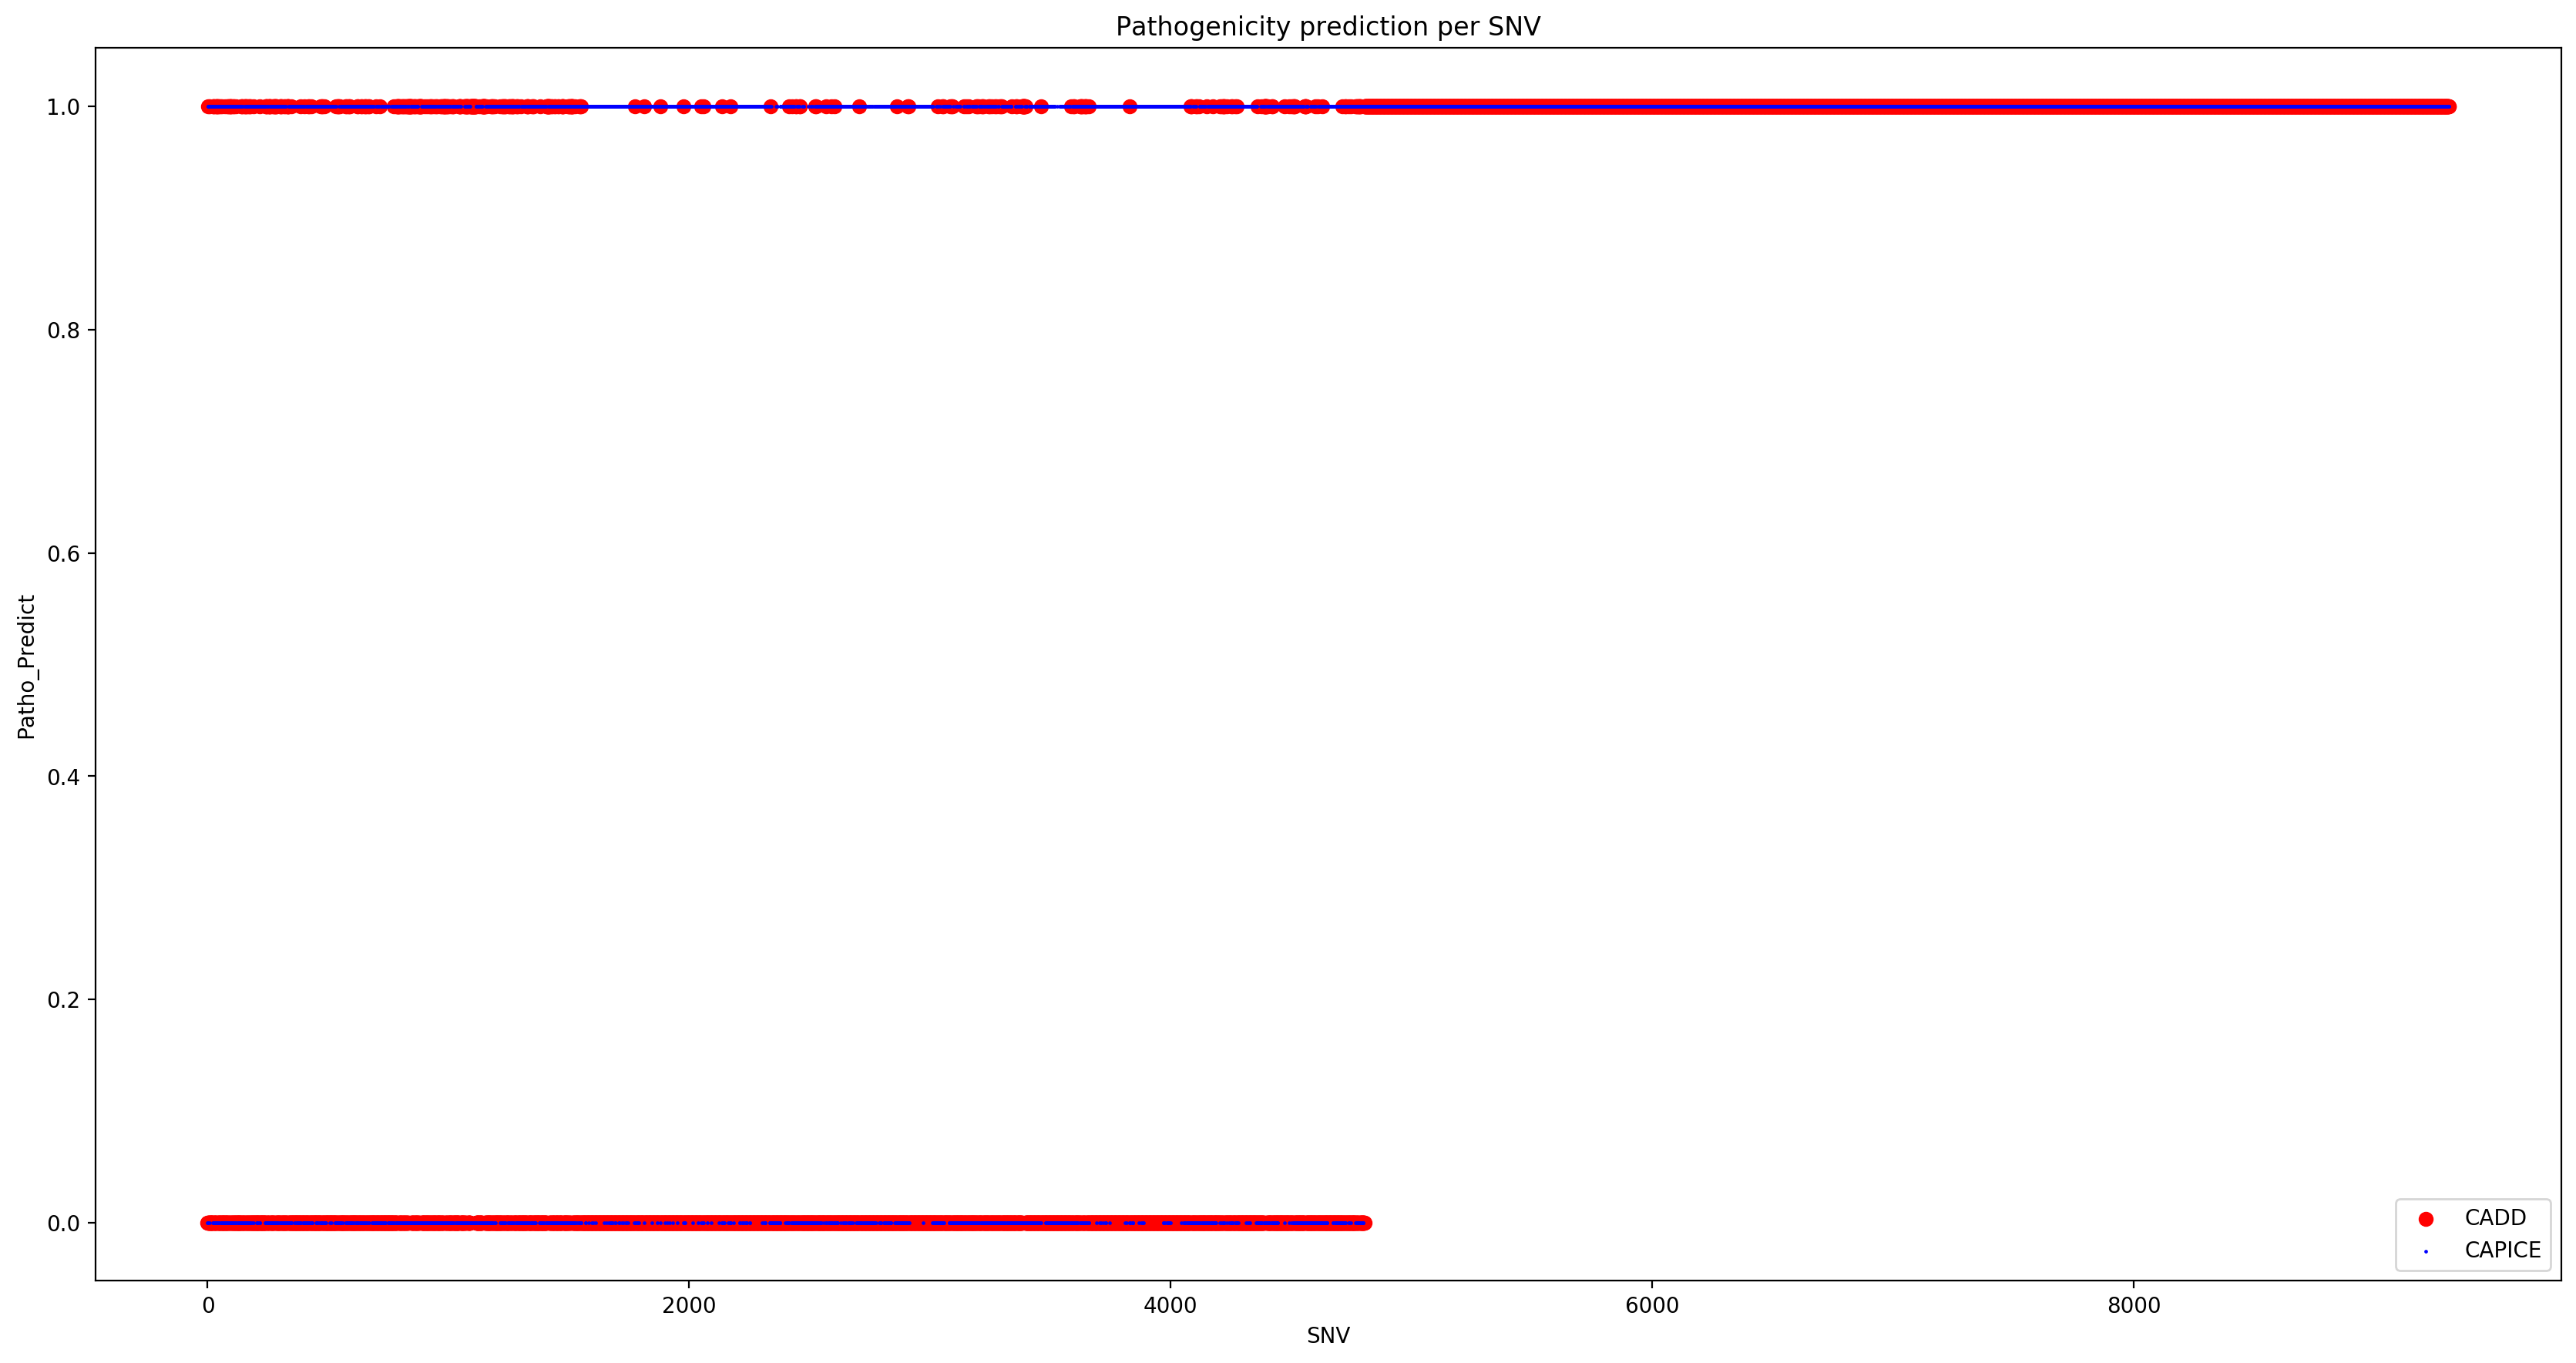

In [62]:
fig = plt.figure(figsize=(20,10), dpi=200)
axes = fig.add_axes([0.1,0.1,0.8,0.8])
inheritence_codeblock62 = inheritence_ieds.copy()
inheritence_codeblock62['cadd_b'] = 0
inheritence_codeblock62['capice_b'] = 0
inheritence_codeblock62['unanimous_cc_b'] = 0
inheritence_codeblock62.loc[
    inheritence_codeblock62[inheritence_codeblock62['PHRED'] >= 30].index, 'cadd_b'] = 1
inheritence_codeblock62.loc[
    inheritence_codeblock62[inheritence_codeblock62['capice'] >= 0.02].index, 'capice_b'] = 1
filter_capice_b = inheritence_codeblock62['capice_b'] == 1
filter_cadd_b = inheritence_codeblock62['cadd_b'] == 1
inheritence_codeblock62.loc[inheritence_codeblock62[inheritence_codeblock62.where(filter_cadd_b & filter_capice_b)['#Chrom'].notnull()].index, 'unanimous_cc_b'] = 1
inheritence_codeblock62.sort_values(by=['unanimous_cc_b'], inplace=True, ignore_index=True)
print(f"Percentage of unanimous decision making: {inheritence_codeblock62[inheritence_codeblock62['unanimous_cc_b'] == 0].shape[0] / inheritence_codeblock62.shape[0] * 100}%")
axes.scatter(inheritence_codeblock62.index, inheritence_codeblock62['cadd_b'], c='red', label='CADD')
axes.scatter(inheritence_codeblock62.index, inheritence_codeblock62['capice_b'], c='blue', label='CAPICE', s=0.5)
# axes.plot(inheritence_codeblock62.index, inheritence_codeblock62['unanimous_cc_b'], c='red', label='Unanimous')
axes.set_xlabel("SNV")
axes.set_ylabel("Patho_Predict")
axes.set_title("Pathogenicity prediction per SNV")
axes.legend()
plt.show()

In [69]:
test_omim = pd.read_csv("/home/rjsietsma/Documents/School/Master_DSLS/Final_Thesis/Initial_Data_exploration/genemap2.txt", header=0, sep='\t', skiprows=3)
test_omim = test_omim[test_omim['Genomic Position Start'].notnull()]
test_omim['# Chromosome'] = test_omim['# Chromosome'].apply(lambda x: x.split("chr")[1])
test_omim = test_omim[['# Chromosome', 'Genomic Position Start', 'Genomic Position End', 'Gene Symbols']]
test_omim.columns = ['chr','start','end','gene']
initial_omim_list = list(test_omim['gene'].unique())
actual_omim_list = []
reset_timer = time.time()
done = 0
total = len(initial_omim_list)
for gene in initial_omim_list:
    time_fls = time.time()
    if time_fls - reset_timer > 10:
        print(f"Still processing, done: {round(done/total*100, ndigits=2)}%")
        reset_timer = time.time()
    gene_split = gene.split(", ")
    if len(gene_split) > 1:
        for g in gene_split:
            if g not in actual_omim_list:
                actual_omim_list.append(g)
    else:
        actual_omim_list += gene_split
    done += 1


Still processing, done: 79.53%


In [73]:
current_gene_list = list(inheritence_ieds['gene'].unique())
reset_timer = time.time()
done = 0
total = len(actual_omim_list)
in_list = 0
actually_in_dataset = []
for gene in actual_omim_list:
    time_fls = time.time()
    if time_fls - reset_timer > 10:
        print(f"Still processing, done: {round(done/total*100, ndigits=2)}%")
        reset_timer = time.time()
#     if gene not in current_gene_list:
#         print(f"OMIM locus is not present in gene list: {gene}")
    if gene in current_gene_list:
        print(f"{gene} is present in the current dataset!")
        actually_in_dataset.append(gene)
        in_list += 1
    done += 1
print(f"Total percentage of OMIM loci in dataset: {round(in_list/total*100, ndigits=2)}%")

DVL1 is present in the current dataset!
TMEM240 is present in the current dataset!
SKI is present in the current dataset!
PEX10 is present in the current dataset!
PRDM16 is present in the current dataset!
NPHP4 is present in the current dataset!
PLEKHG5 is present in the current dataset!
CAMTA1 is present in the current dataset!
RERE is present in the current dataset!
PIK3CD is present in the current dataset!
KIF1B is present in the current dataset!
MTOR is present in the current dataset!
UBIAD1 is present in the current dataset!
NPPA is present in the current dataset!
MFN2 is present in the current dataset!
AUH is present in the current dataset!
EPHA2 is present in the current dataset!
ATP13A2 is present in the current dataset!
SDHB is present in the current dataset!
PINK1 is present in the current dataset!
DDOST is present in the current dataset!
ALPL is present in the current dataset!
HSPG2 is present in the current dataset!
EPHB2 is present in the current dataset!
KDM1A is present 

DIAPH1 is present in the current dataset!
POU4F3 is present in the current dataset!
SPINK1 is present in the current dataset!
SPINK5 is present in the current dataset!
SH3TC2 is present in the current dataset!
SLC26A2 is present in the current dataset!
CSF1R is present in the current dataset!
PDGFRB is present in the current dataset!
TCOF1 is present in the current dataset!
NIPAL4 is present in the current dataset!
GABRA1 is present in the current dataset!
GABRG2 is present in the current dataset!
NKX2-5 is present in the current dataset!
MSX2 is present in the current dataset!
GRIN1 is present in the current dataset!
NSD1 is present in the current dataset!
DDX41 is present in the current dataset!
B4GALT7 is present in the current dataset!
ADAMTS2 is present in the current dataset!
SQSTM1 is present in the current dataset!
FOXC1 is present in the current dataset!
TUBB2A is present in the current dataset!
TUBB2B is present in the current dataset!
DSP is present in the current dataset!
A

FGF8 is present in the current dataset!
PITX3 is present in the current dataset!
NFKB2 is present in the current dataset!
SUFU is present in the current dataset!
COL17A1 is present in the current dataset!
SMC3 is present in the current dataset!
RBM20 is present in the current dataset!
SHOC2 is present in the current dataset!
TCF4 is present in the current dataset!
KCNK18 is present in the current dataset!
NANOS1 is present in the current dataset!
BAG3 is present in the current dataset!
FGFR2 is present in the current dataset!
OAT is present in the current dataset!
ECHS1 is present in the current dataset!
HRAS is present in the current dataset!
SLC25A22 is present in the current dataset!
TNNI2 is present in the current dataset!
IGF2 is present in the current dataset!
INS is present in the current dataset!
TH is present in the current dataset!
KCNQ1 is present in the current dataset!
CDKN1C is present in the current dataset!
HBB is present in the current dataset!
SMPD1 is present in the 

CYLD is present in the current dataset!
SALL1 is present in the current dataset!
RPGRIP1L is present in the current dataset!
GNAO1 is present in the current dataset!
BBS2 is present in the current dataset!
SLC12A3 is present in the current dataset!
TK2 is present in the current dataset!
HSF4 is present in the current dataset!
CTCF is present in the current dataset!
LCAT is present in the current dataset!
PRMT7 is present in the current dataset!
CDH1 is present in the current dataset!
COG4 is present in the current dataset!
TAT is present in the current dataset!
DHODH is present in the current dataset!
WWOX is present in the current dataset!
MAF is present in the current dataset!
GAN is present in the current dataset!
IRF8 is present in the current dataset!
FOXC2 is present in the current dataset!
ZNF469 is present in the current dataset!
CTU2 is present in the current dataset!
PIEZO1 is present in the current dataset!
CDH15 is present in the current dataset!
ANKRD11 is present in the c

KDM5C is present in the current dataset!
IQSEC2 is present in the current dataset!
HUWE1 is present in the current dataset!
PHF8 is present in the current dataset!
FGD1 is present in the current dataset!
ARHGEF9 is present in the current dataset!
AMER1 is present in the current dataset!
MSN is present in the current dataset!
AR is present in the current dataset!
OPHN1 is present in the current dataset!
EFNB1 is present in the current dataset!
EDA is present in the current dataset!
TEX11 is present in the current dataset!
IL2RG is present in the current dataset!
MED12 is present in the current dataset!
NONO is present in the current dataset!
TAF1 is present in the current dataset!
HDAC8 is present in the current dataset!
PHKA1 is present in the current dataset!
ZDHHC15 is present in the current dataset!
ATRX is present in the current dataset!
ATP7A is present in the current dataset!
ZNF711 is present in the current dataset!
CHM is present in the current dataset!
PCDH19 is present in the

Now to do: map these omim genes and look up their AUC.
Map the infever genes to own genes [Infevers](https://infevers.umai-montpellier.fr/web/)

__Priority share research proposal for approval by Joeri and Shuang__ 
